# Modélisation et prédiction : consommation d'énergie et émission de CO2
Concernant la partie “modélisation”, on cherche à prédire des variables quantitatives 
(la consommation d’énergie en kBtu et les émissions de CO2) : on a donc affaire à un problème de régression. 
Les variables que l’on cherche à prédire ne suivent pas une loi normale, on va donc faire une transformation logarithmique 
avant de tester plusieurs modèles. 
La transformation logarithmique permet de ne pas perturber les modèles qui sont sensibles au respect de la loi normale.

## 1/ Importation des librairies nécessaires aux tests de modèle :

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error,mean_squared_log_error, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score, cross_val_predict, RandomizedSearchCV
from yellowbrick.regressor import ResidualsPlot, prediction_error
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor   # importation de l'estimateur
import time

## 2/ Les Fonctions de calculs et d'affichage :

In [2]:
# Fonction permettant de calculer le RMSPE
# source : https://stackoverflow.com/questions/53165807/how-to-calculate-rmspe-in-python-using-numpy
def rmpse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

    return loss
#==============================================================================================================================
# Evaluation des modèles de régression
def calcul_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE, MAPE & R² score  
    """
    mae = (mean_absolute_error(y_test, y_pred)).round(5)
    mse = (mean_squared_error(y_test, y_pred)).round(5)
    rmse = (np.sqrt(mse)).round(5)
    rmpse_cal = (rmpse(y_test, y_pred)).round(5)
    mape = (mean_absolute_percentage_error(y_test, y_pred))
    r_score = (r2_score(y_test, y_pred, multioutput="variance_weighted")).round(5)
    print("MAE = ", mae)
    print("MSE = ", mse)
    print("RMSE = ", rmse)
    print("RMPSE = ", rmpse_cal)
    print("MAPE = ", mape)
    print("R^2 = ", r_score)
#===============================================================================================================================        
# Description des colonnes
def frequence(D):
    for v in D.columns:
        if (D[v].dtype == 'object'):
            print(D[v].value_counts())
            print('----')
#===============================================================================================================================            
# Pourcentage du split Data_set et Test_set
def pourcentage_train_test_set(data,train_set,test_set,X_test,y_test,X_train,y_train):
    prct_Train_set= (train_set.shape[0]/data.shape[0])*100
    prct_test_set=(test_set.shape[0]/data.shape[0])*100
    print('Dimensions du Train set:', X_train.shape)
    print ("Pourcentage du train_set =", (prct_Train_set,"% du dataset"))  
    print("")
    print('Dimensions du Test set:', X_test.shape)
    print ("Pourcentage du test_set =", (prct_test_set,"% du dataset"))
    print("")
    print('Dimensions du Y_train:', y_train.shape)
    print('Dimensions du  Y_test:', y_test.shape)
#===============================================================================================================================            
# Info data_set
def info(D):
    D.info()
#===============================================================================================================================
# Nom de chaque colonne
def columns_name(D):
    print(D.columns)
#===============================================================================================================================
# Qualité du split par variable 
def split_quality_by_feature(train_set, test_set,var):
    feature=var
    split_quality_train = train_set[feature]
    split_quality_test = test_set[feature]
    plt.hist([split_quality_train,split_quality_test],bins=30, histtype = 'barstacked',color =['green','blue'],label = [('train_set', feature), ('test_set', feature)])
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.xlabel(feature)
    plt.title('Qualité de la Répartition dans la variable')
    plt.legend() 
#===============================================================================================================================
# Affichage graphique du résultat de regression " scatter(y_true, y_pred) "
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--r", linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0)
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.4f} min".format(elapsed_time)
    ax.set_title(title)     
#===============================================================================================================================
# Fonction performance des modèles avec des hyperparamètres par défaut
def models_perf_default_params (estimators, subplot_rows, subplot_columns, width_fig, height_fig):
    global dict_model
    dict_model={}
    fig, axs = plt.subplots(subplot_rows, subplot_columns, figsize=(width_fig, height_fig))
    axs = np.ravel(axs)
    for ax, (name, est) in zip(axs, estimators):
        start_time = time.time()
        est.fit(X_train, y_train)  
        # Prédictions du modèle     
        y_pred = est.predict(X_test)                              
        # Metrics ( Mesure des performances de chaque modèle)
        mae = mean_absolute_error(y_test, y_pred) 
        mse = mean_squared_error(y_test, y_pred) 
        rmse = np.sqrt(mse)
        r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3) 
        r_score=(r_score*100).round(3)
        #  Disctionnaire des performances de chaque modèle
        elapsed_time = time.time() - start_time
        dict_model[name] = (mae.round(3), mse.round(3), rmse.round(3), (r"{:.2f}").format(r_score) ,(r"{:.4f}").format(elapsed_time/60)) 
        plot_regression_results(
            ax, 
            #np.array(y_test), 
            np.array(y_test), 
            y_pred, 
            name,       
            (r"$R^2={:.2f}" + "%" + "\n" + r"$MAE={:.2f}" + "\n" + r"$MSE={:.2f}" + "\n" + r"$RMSE={:.2f}").format(
                r_score, 
                mae,
                mse, 
                rmse,
            ), 
            elapsed_time/60,
        )
    
    plt.suptitle("models performances with default parameters without stacking")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

#===============================================================================================================================
# Fonction randomsearchCV avec un premier résultat d'hyperparamètres et performances des modèle   
def Random_search (estimators,parameters, n_iter, cv,scoring, random_state):
    global name
    global elapsed_time,best_est,best_param,best_score
    for (name, est) in (estimators):
        start_time = time.time()
        # RandomizedSearchCV
        rnd_search = RandomizedSearchCV(est, param_distributions=parameters[name],
                                        n_iter=n_iter, cv=cv, scoring=scoring, random_state=random_state)
        # Entrainement du modèle sur les données d'entrainement
        rnd_search.fit(X_train, y_train)
        elapsed_time =(time.time() - start_time)/60   
        best_est =rnd_search.best_estimator_
        best_param= rnd_search.best_params_
        best_score=rnd_search.best_score_
        # Appel de la Fonction d'affichage des résultats le la recherche aléaoire pour chaque modèle.
        Results_RandSearchCV (name,elapsed_time,best_est,best_param,best_score)
#===============================================================================================================================
# Affichage des résultats de la recherche aléatoire des meilleurs hyperparamètres 
def Results_RandSearchCV (name,elapsed_time,best_est,best_param,best_score):
    print("")
    # Results from Random Search
    print("")
    # Results from Random Search
    print("\n===============================================================================================================================")    
    print("                                               Results from RandomizedSearchCV                                                ")
    print("===============================================================================================================================")        
    print(                           name," : ", "elapsed_time = ", (r"{:.2f}").format(elapsed_time), " min"                      )
    print("                          ====================================================================                                ")
    print("\n The best estimator across ALL searched params:\n", best_est)
    print("\n RMSE = ",-(best_score).round(4))
    print("\n The best parameters across ALL searched params:\n", best_param) 
#===============================================================================================================================
# Fonction GridSearchCV avec selection du modèle final 
def Grid_Search (estimators,parameters, cv,scoring,subplot_rows,subplot_columns,width_fig,height_fig):
    global Model_name,final_model
    global elapsed_time,model_energy,best_param,best_score,dict_metrics_GSCV
    dict_model_var = {}
    dict_metrics_GSCV = {}
    RMSE_MIN=0.8 # Définisson un précision de l'algorithme exigée par le métier
    elapsed_time_max = 15 # Définissons une exigence métier d'une rapidité de traitement maximale de 15 min 

    ################################## Figure d'affichage des résultats #################################    
    fig, axs = plt.subplots(subplot_rows, subplot_columns, figsize=(width_fig, height_fig))
    axs = np.ravel(axs)

    ############## GridSearchCV pour tous les estimateurs, choix du meilleur estimateur et bilan du modèle choisi ################## 
    for ax, (name, est) in zip(axs, estimators):
        start_time = time.time()
        # GridSearchCV
        grid_search = GridSearchCV(est, parameters[name], cv=cv, scoring=scoring)
        grid_search.fit(X_train, y_train)
        grid_search.get_params()
        model_energy = grid_search.best_estimator_ 
        best_param= grid_search.best_params_
        best_score=grid_search.best_score_
        # Prédictions avec le meilleur modèle
        predictions_energy = model_energy.predict(X_test)
        # métriques du meilleur modèle
        # Calcul des métriques
        mae_ = mean_absolute_error(np.array(y_test), predictions_energy) # Calcul de la MAE
        mse_ = mean_squared_error(np.array(y_test), predictions_energy) # Calcul de la MSE
        rmse_ = np.sqrt(mse_) # Calcul de la RMSE
        r_score_ = r2_score(np.array(y_test), predictions_energy, multioutput="variance_weighted").round(3)
        r_score=(r_score_*100).round(3)
        elapsed_time = (time.time() - start_time)/60
        # Dictionnaire des métriques
        dict_metrics_GSCV[name] = ((r"{:.2f}").format(mae_), (r"{:.2f}").format(mse_),
                                   (r"{:.2f}").format(grid_search.best_score_),(r"{:.2f}").format(r_score),(r"{:.2f}").format(elapsed_time))

        # Appel de la fonction d'afficahge des résultats "y_pred VS y_test"
        plot_regression_results(
            ax, 
            np.array(y_test), 
            predictions_energy, 
            name, 
            (r"$R^2={:.2f}" + "%" + "\n" + r"$MAE={:.2f}" + "\n" + r"$MSE={:.2f}" + "\n" + r"$RMSE={:.2f}").format(
                r_score, # R2
                mae_,
                mse_,
                -(grid_search.best_score_),   # RMSE
            ), 
            elapsed_time,
        )
        ############## Sauvegarde du modèle le plus performant (RMSE la plus basse) ####################  
        if (-(grid_search.best_score_))< RMSE_MIN and elapsed_time < elapsed_time_max:
            RMSE_MIN = -(grid_search.best_score_.round(4))
            final_model = model_energy   # Attribution du modèle entraîné à une variable

        # Appel de la fonction résultats
        Results_GridSearchCV (name,elapsed_time,model_energy,best_param,best_score)
    ##############################################################################################################################        

    ### Affichage du titre des graphiques ########
    plt.suptitle("Single predictors versus stacked predictors With GridSearchCV")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show() 
#===============================================================================================================================
# Affichage des résultats de la recherche des meilleurs hyperparamètres par GridSearchCV
def Results_GridSearchCV (name,elapsed_time,best_est,best_param,best_score):
    print("")
    # Results from Random Search
    print("")
    # Results from Random Search
    print("\n===============================================================================================================================")    
    print("                                               Results from GridsearchCV                                                ")
    print("===============================================================================================================================")        
    print(                           name," : ", "elapsed_time = ", (r"{:.2f}").format(elapsed_time), " min"                      )
    print("                          ====================================================================                                ")
    print("\n The best estimator across ALL searched params:\n", best_est)
    print("\n RMSE = ",-(best_score).round(4))
    print("\n The best parameters across ALL searched params:\n", best_param) 
#===============================================================================================================================         
# Fonction d'évaludation des modèles (Learning Curve)
def evaluation (model , X_train, y_train,X_test,cv,width_fig,height_fig,scoring):
    
        model.fit(X_train, y_train)
        ypred = model.predict(X_test)
        N, train_score, val_score = learning_curve(model, X_train, y_train, cv=cv, scoring=scoring, 
                                               train_sizes=np.linspace(0.1,1,10))
        plt.figure(figsize=(width_fig,height_fig))
        plt.plot(N,-train_score.mean(axis=1), label = "Train score")
        plt.plot(N,-val_score.mean(axis=1), label = "Val score")
        plt.title("Learning Curve :")
        plt.legend()
        plt.show()

## 3/ Importation des données

In [3]:
# importation des données
data = pd.read_csv("building-energy-benchmarking.csv")
data.head(5)

PrimaryPropertyType Neighborhood  YearBuilt  NumberofBuildings  \
0               Hotel     downtown       1927                1.0   
1               Hotel     downtown       1927                1.0   
2               Hotel     downtown       1996                1.0   
3               Hotel     downtown       1996                1.0   
4               Hotel     downtown       1969                1.0   

   NumberofFloors  PropertyGFATotal SecondLargestPropertyUseType  \
0            12.0             88434                          N_C   
1            12.0             88434                          N_C   
2            11.0            103566                      Parking   
3            11.0            103566                      Parking   
4            41.0            961990                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                             -1.0                         N_C   
1                             -1.0                         N_C   
2                          15064.0                  Restaurant   
3                          15064.0                  Restaurant   
4                         100000.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
0                            -1.0             65.0            6981428.0   
1                            -1.0             60.0            7226362.5   
2                          4622.0             51.0            8354235.0   
3                          4622.0             61.0            8387933.0   
4                             0.0             18.0           73130656.0   

   TotalGHGEmissions  Latitude  Longitude  Age Parking  Clusters  
0             249.43  47.61220 -122.33799   88      NO         1  
1             249.98  47.61220 -122.33799   89      NO         1  
2             263.51  47.61317 -122.33393   19     YES         1  
3             295.86  47.61317 -122.33393   20     YES         1  
4            2061.48  47.61393 -122.33810   46      NO         1

In [5]:
# Appel de la fonction infos concernant les colonnes
info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6609 entries, 0 to 6608
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              6609 non-null   object 
 1   Neighborhood                     6609 non-null   object 
 2   YearBuilt                        6609 non-null   int64  
 3   NumberofBuildings                6609 non-null   float64
 4   NumberofFloors                   6601 non-null   float64
 5   PropertyGFATotal                 6609 non-null   int64  
 6   SecondLargestPropertyUseType     6609 non-null   object 
 7   SecondLargestPropertyUseTypeGFA  6609 non-null   float64
 8   ThirdLargestPropertyUseType      6609 non-null   object 
 9   ThirdLargestPropertyUseTypeGFA   6609 non-null   float64
 10  ENERGYSTARScore                  5046 non-null   float64
 11  SiteEnergyUse(kBtu)              6609 non-null   float64
 12  TotalGHGEmissions   

In [6]:
# Appel de la fonction de vérification des modalités 
frequence(data)

Low-Rise Multifamily     1951
Mid-Rise Multifamily     1098
Office                   1001
Other                     501
Warehouse                 450
Supermarket/Store         262
K-12 School               258
Mixed Use Property        257
High-Rise Multifamily     208
Hotel                     150
Worship Facility          142
Distribution Center       106
Senior Care Community      88
University                 46
Residence Hall             38
Restaurant                 22
Hospital                   20
Laboratory                 11
Name: PrimaryPropertyType, dtype: int64
----
downtown                 1130
east                      888
magnolia / queen anne     828
greater duwamish          738
northeast                 532
lake union                492
northwest                 437
north                     367
southwest                 326
central                   258
ballard                   258
southeast                 188
delridge                  166
Delridge                 

On sépare notre jeu de données en deux parties : 

> un train set

> un test set 

On ne va pas toucher aux données du test set car il nous servira pour la validation de notre modèle. 
C'est grâce à ce jeu de données que l'on pourra sortir les metrics nécessaires.
Dans chaque jeu (entraînement et test), on supprime les variables qui ne seront pas utiles dans notre modélisation.

Notre jeu de données comporte de nombreuses valeurs : certaines sont d'origine et d'autres proviennent d'une opération de feature engineering ("Age" & "Parking" & "Clusters"). On va donc supprimer les doublons pour éviter la fuite de donneés.

Nous allons supprimer : 

* "SiteEnergyUse(kBtu)" : Cible consomation d'énergie qu'on cherche à prédire
* "TotalGHGEmissions"   : Cible emission CO2 qu'on cherche à prédire      
* Le score "ENERGYSTAR" :  on ne va pas s'en servir pour prédire la consommation d'énergie. 
* L'année de construction "YearBuilt" : On préfère utiliser la variable "Age".
* Le quartier "Neighborhood"; La longitude "Longitude"; La latitude "Latitude": L'information de la localisation se trouve dans                                                                                 la variable "Clusters"

## Nous avons vu dans l'analyse exploratoire que les variables ne suivent pas une loi normale, donc nous allons faire une transformation logarithmique des variables cibles :
Le passage au log aide le modèle à trouver de la précision, car il permet de 'resserrer' l'intervalle sur lequel la target est exprimée. 

In [4]:
# passage au log des variables cibles
data["SiteEnergyUse(kBtu)_log"] = np.log(data["SiteEnergyUse(kBtu)"])
data["TotalGHGEmissions_log"] = np.log(data["TotalGHGEmissions"])

In [8]:
# Appel de la fonction nom de chaque colonne
columns_name(data)

Index(['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'Latitude', 'Longitude',
       'Age', 'Parking', 'Clusters', 'SiteEnergyUse(kBtu)_log',
       'TotalGHGEmissions_log'],
      dtype='object')


#### On va créer un jeu d'entrainement et un jeu de test égale à 20% du jeu de données total.
On fait une stratification sur la variable "PrimaryPropertyType" afin d'éviter que le  jeu d’entraînement et le jeu de test ne contiennent que des exemples identiques ou des exemples déséquilibrés en terme de proportion, ce qui va affecter négativement la performance du modèle !

In [9]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
# Stratification sur la variable "type de propriété"
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

X_train = train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "YearBuilt","Neighborhood", "Latitude", "Longitude"], axis=1)
y_train = train_set[["SiteEnergyUse(kBtu)_log"]]

X_test = test_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "YearBuilt","Neighborhood", "Latitude", "Longitude"], axis=1)
y_test = test_set[["SiteEnergyUse(kBtu)_log"]]

# Appel fonction de calcul du pourcentage de : Train_set, test_set, y_test, y_train, X_test, y_test
pourcentage_train_test_set(data,train_set,test_set,X_test,y_test,X_train,y_train)


Dimensions du Train set: (5287, 11)
Pourcentage du train_set = (79.99697382357391, '% du dataset')

Dimensions du Test set: (1322, 11)
Pourcentage du test_set = (20.003026176426086, '% du dataset')

Dimensions du Y_train: (5287, 1)
Dimensions du  Y_test: (1322, 1)


In [10]:
info(X_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5287 entries, 1340 to 4436
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              5287 non-null   object 
 1   NumberofBuildings                5287 non-null   float64
 2   NumberofFloors                   5280 non-null   float64
 3   PropertyGFATotal                 5287 non-null   int64  
 4   SecondLargestPropertyUseType     5287 non-null   object 
 5   SecondLargestPropertyUseTypeGFA  5287 non-null   float64
 6   ThirdLargestPropertyUseType      5287 non-null   object 
 7   ThirdLargestPropertyUseTypeGFA   5287 non-null   float64
 8   Age                              5287 non-null   int64  
 9   Parking                          5287 non-null   object 
 10  Clusters                         5287 non-null   int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 495.7+ KB


In [11]:
frequence(X_train)

Low-Rise Multifamily     1561
Mid-Rise Multifamily      878
Office                    801
Other                     401
Warehouse                 360
Supermarket/Store         209
Mixed Use Property        206
K-12 School               206
High-Rise Multifamily     166
Hotel                     120
Worship Facility          114
Distribution Center        85
Senior Care Community      70
University                 37
Residence Hall             30
Restaurant                 18
Hospital                   16
Laboratory                  9
Name: PrimaryPropertyType, dtype: int64
----
N_C                                                     2733
Parking                                                 1475
Office                                                   347
Supermarket/Store                                        256
Other                                                     96
Restaurant                                                64
Warehouse                                        

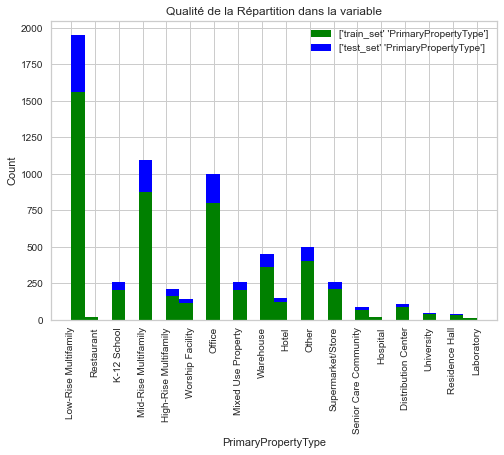

In [12]:
split_quality_by_feature(train_set, test_set,'PrimaryPropertyType')

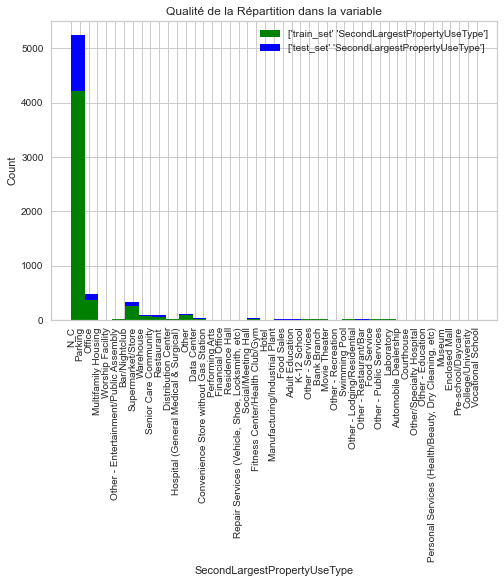

In [13]:
split_quality_by_feature(train_set, test_set,'SecondLargestPropertyUseType')

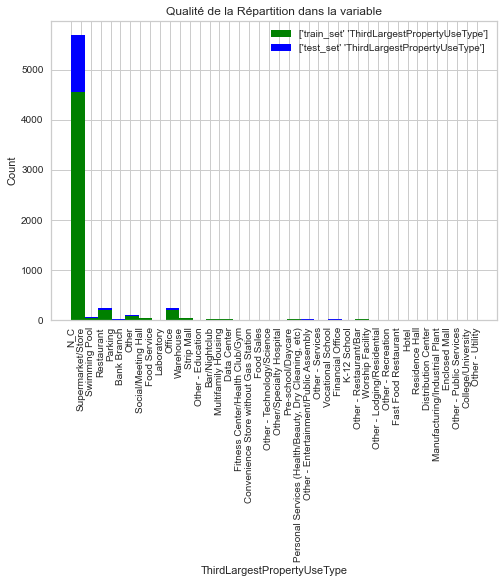

In [14]:
split_quality_by_feature(train_set, test_set,'ThirdLargestPropertyUseType')

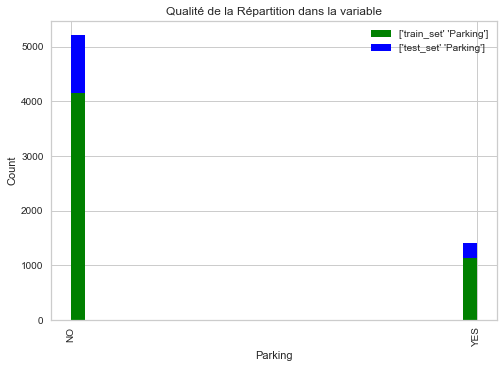

In [15]:
split_quality_by_feature(train_set, test_set,'Parking')

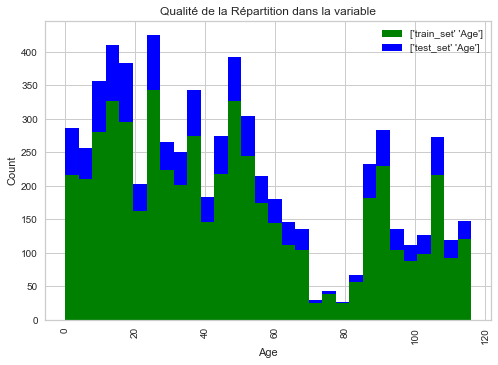

In [16]:
split_quality_by_feature(train_set, test_set,'Age')

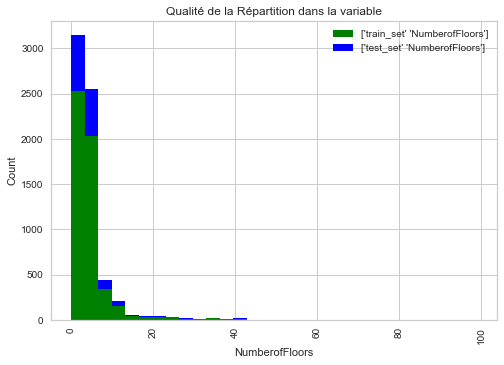

In [17]:
split_quality_by_feature(train_set, test_set,'NumberofFloors')

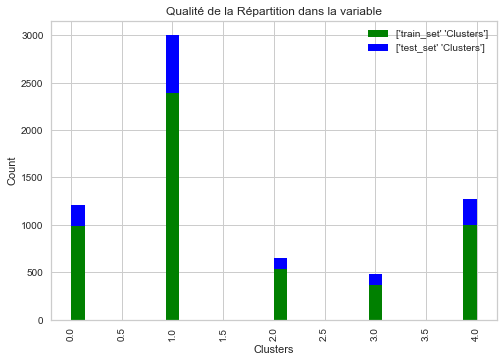

In [18]:
split_quality_by_feature(train_set, test_set,'Clusters')

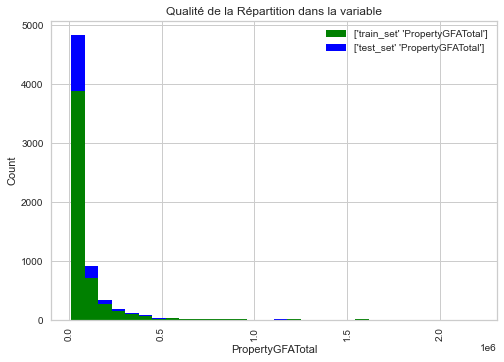

In [19]:
split_quality_by_feature(train_set, test_set,'PropertyGFATotal')

In [20]:
train_set['PrimaryPropertyType'].value_counts()

Low-Rise Multifamily     1561
Mid-Rise Multifamily      878
Office                    801
Other                     401
Warehouse                 360
Supermarket/Store         209
Mixed Use Property        206
K-12 School               206
High-Rise Multifamily     166
Hotel                     120
Worship Facility          114
Distribution Center        85
Senior Care Community      70
University                 37
Residence Hall             30
Restaurant                 18
Hospital                   16
Laboratory                  9
Name: PrimaryPropertyType, dtype: int64

In [21]:
test_set['PrimaryPropertyType'].value_counts()

Low-Rise Multifamily     390
Mid-Rise Multifamily     220
Office                   200
Other                    100
Warehouse                 90
Supermarket/Store         53
K-12 School               52
Mixed Use Property        51
High-Rise Multifamily     42
Hotel                     30
Worship Facility          28
Distribution Center       21
Senior Care Community     18
University                 9
Residence Hall             8
Restaurant                 4
Hospital                   4
Laboratory                 2
Name: PrimaryPropertyType, dtype: int64

### Detection des valeurs manquantes 

In [22]:
X_train.isna().sum()

PrimaryPropertyType                0
NumberofBuildings                  0
NumberofFloors                     7
PropertyGFATotal                   0
SecondLargestPropertyUseType       0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseType        0
ThirdLargestPropertyUseTypeGFA     0
Age                                0
Parking                            0
Clusters                           0
dtype: int64

In [23]:
X_test.isna().sum()

PrimaryPropertyType                0
NumberofBuildings                  0
NumberofFloors                     1
PropertyGFATotal                   0
SecondLargestPropertyUseType       0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseType        0
ThirdLargestPropertyUseTypeGFA     0
Age                                0
Parking                            0
Clusters                           0
dtype: int64

Il n'y a pas de valeurs manquantes dans les variables catégorielles. 

1/ On va donc les transformer directement en valeurs numériques via OneHotEncoding compréhensible par nos modèles 

Si on avait des valeurs manquantes existantes, on les aurait remplacer par le mode (celle qui est le plus fréquent)
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))

dans notre cas, on se contente de les transformer via un OneHotEncoding. Ainsi, elles seront transformées en valeur numérique 
compréhensible par notre modèles.

#### Il y a 8 valeurs manquantes dans la variable "NumberofFloors".

Afin de remplacer le nombre d'étages manquant pour les 8 immeubles concernés, nous allons utiliser le KNNImputer qui va remplacer les valeurs manquantes par les valeurs de l'échantillon qui resemble le plus. Ici nous avons 8 batiments dont nous ignorons le nombre d'étages mais dont nous connaissons leurs surfaces total respectives. alors on les comparant avec les autres batiments, nous serrons capable de définir leur nombre d'étages. 

1/ On complète les valeurs manquantes par le KNN-IMPUTER (K=1)

2/ On standardise nos variables pour enlever les unités qui sont différents (sq/ft² pour la taille de la propriété, Age, etc..)

On sépare les variables catégorielles des variables numériques. Pour pouvoir leur appliquer des traitements différents qui seront enregistrés dans un pipeline de préprocessing. 

In [24]:
# Séparation des variables catégorielles et numériques
cat_selector  = ["PrimaryPropertyType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "Parking"]
num_selector  = ["PropertyGFATotal","Age","Clusters", "NumberofBuildings", "NumberofFloors", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]

In [25]:
# Création d'un pipeline de transformation
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])
num_pipe = Pipeline([('imputer', KNNImputer(n_neighbors=1)),('scaler', StandardScaler())])

### Pipeline de préprocessing et transformation des variables

In [26]:
preprocessor = ColumnTransformer(transformers=[('cat', cat_pipe, cat_selector),('num', num_pipe, num_selector)])

In [27]:
# transformation des variables
X_train = preprocessor.fit_transform(X_train)
X_test= preprocessor. transform(X_test)

print ("X test shape: ",X_test.shape)
print ("X train shape: ",X_train.shape)

X test shape:  (1322, 113)
X train shape:  (5287, 113)


# Prédiction de la consommation d'énergie : 
### -------------------------------------------------------------------------------------
#### 1/ Création d'un modèle "baseline" : 

 - Choix d'un modèle naïf "DummyRegressor" qui prédit la valeur médiane de la variable cible. 
 - Evaluation du modèle avec le jeu de test
 - Les métriques qui sortiront de ce modèle serviront de base pour évaluer les performances des autres modèles.
 
#### 2/ Mesure des performances multi-prédicteurs y compris le stracking : 

 - Instanciation des estimateurs
 - Metriques mesurés : R^2,MAE,MSE,RMSE,Temps de traitement
###### 2.1/  On laisse les hyperparamètres par défaut et on mesure les performances. 

 - On créer une liste d'estimateurs pour mesurer leurs performance sans optimisation des hyperparamètres 
 - On entraine les estimateurs avec leurs paramètres par défaut
 - On mesure leurs performances 
 - On trace les résultats au format Graphique 
 - On créer un tableau comparatif des performances. 
 - On élimine les modèles non performants ou qui ne correspondent pas à notre problématique 
###### 2.2/  Mesure des performances de chaque modèle avec ses meilleurs hyperparamètres  

 - Pour chaque estimateur, on cherche les meilleurs Hyperparamètres en appliquant une RandomizedSearchCV
 - Grâce à la RandomizedSearchCV, pour chaque estimateur, on cherche une seconde fois les meilleurs Hyperparamètres avec une GridSearchCV. Ceci réduira significativement le temps de traitement. 
 - Nous selectionnons le modèle le plus performant en trouvant le juste équilibre entre précision et temps de traitement
 - Nous analyserons ensuite les erreurs du modèle sélectionné
 - Nous visualiserons sur un Graphique les distributions des résidus sur le jeu d'entraînement et le jeu de test
 - On fera une analyse des variables importantes (bilan du modèle)
###### 2.3/ Création d'un pipeline

 - On écrit un pipeline contenant la transformation des variables et le modèle entraîné 
 - On vérifie si le modèle est capable encore d'améliorer ses performances en lui fournissant plus de données en traçant les   
   courbes d'apprentissage (évolution de la performance du modèle en fonction de la quantité de données qu'on lui fournit). Pour cela on utilise une Validation_curve.

# 1/ Création d'un modèle "baseline"

Le modèle choisi pour obtenir une baseline est un modèle naïf "DummyRegressor" qui prédit la valeur médiane de la variable cible. 
Le but étant d'avoir une prédiction proche de ce que ferait un modèle basé sur la prédiction aléatoire.
Les métriques qui sortiront de ce modèle serviront de base pour évaluer les performances des autres modèles.

### Entrainement du modèle naîf qui prédit une valeur médiane

In [28]:
# On créer le modèle naîf "médiane"
dummy_reg = DummyRegressor(strategy="median")

# On entraine le modèle naîf sur les données d'entrainement
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

### Evaluation du modèle avec le jeu de test 

In [29]:
# Evaluation du modèle naîf
y_pred = dummy_reg.predict(X_test)
calcul_metrics(np.array(y_test), y_pred)

MAE =  0.89532
MSE =  1.30558
RMSE =  1.14262
RMPSE =  0.07467
MAPE =  0.06012549318248916
R^2 =  -0.02847


##### Les mesures affichées pour cette méthode sont : 
MAE,  MSE (qui s'exprime en log²),  RMSE (qui s'exprime en log),  RMPSE (% de RMSE pour mieux comparer), MAPE,  R² (coefficient de détermination)

# 2/ Mesure de performances Multi-prédicteurs y compris le stacking : 

Notre problème est un problème de régression, on choisira donc pour l'évaluation les modèles adaptés à ce type de prédiction. 
Les modèles qu'on évaluera sont donc : 

### Méthodes linéaires : 
> Régression linéaire

> Régression linéaire régularisée (Ridge)

> Régression linéaire régularisée (Lasso)

> SVM ( Support Vecteur Machine)

### Méthodes non linéaires : 
> Régression linéaires Ridge avec noyau

### Méthodes ensemblistes  : 

> Random Forest

### Méthodes de Boosting : 
> AdaBoost

> Gradient Boosting

> XGBoost

### Méthodes de stacking : 
> StackingRegressor


In [5]:
# instanciation des modèles : 
################################## Dummy Regressor ##################################
Dum_reg= DummyRegressor(strategy="median")
################################## Linear Regression ################################
Lr_reg=LinearRegression()
################################## Lasso ############################################
lasso_reg=Lasso(random_state=42)
################################## LassoCV ##########################################
lasso_cv_reg=LassoCV(cv=10)
################################## Ridge ############################################
Ridge_reg=Ridge(random_state=42)
################################## KernelRidge ######################################
Kernel_Ridge_reg=KernelRidge()
################################## RidgeCV ##########################################
Ridge_CV_reg=RidgeCV(cv=10)
################################# RandomForestRegressor #############################
forest_reg =RandomForestRegressor(random_state=42,n_jobs=-1)
################################# GradientBoostingRegressor #########################
gbdt_reg =GradientBoostingRegressor(random_state=42)
################################# HistGradientBoostingRegressor #####################
hgbdt_reg =HistGradientBoostingRegressor(random_state=42)
#################################### AdaBoostRegressor ##############################
AdaBoost_reg =AdaBoostRegressor(random_state=42)
#################################### DecisionTreeRegressor ##########################
DecisionTree_reg =DecisionTreeRegressor(random_state=42)
#################################### SVR ############################################
SVR_reg =SVR()
#################################### xgboost ########################################
Xgb_reg =xgb.XGBRegressor(random_state=42)

################ estimators list used with for models performances analysis with default parameters #####################
estimators = [
    ("DummyRegressor", Dum_reg),
    ("LinearRegression", Lr_reg),
    ("Lasso", lasso_reg),
    ("LassoCV", lasso_cv_reg),
    ("Ridge", Ridge_reg),
    ("KernelRidge", Kernel_Ridge_reg),
    ("RidgeCV", Ridge_CV_reg),
    ("RandomForest", forest_reg),
    ("GradientBoosting", gbdt_reg),
    ("HistGradientBoosting", hgbdt_reg),
    ("DecisionTreeRegressor", DecisionTree_reg),
    ("SVR", SVR_reg),
    ("xgBoost", Xgb_reg),
    ("AdaBoost", AdaBoost_reg)
]
#####################################  estimators list used by GridSearchCV ############################################
estimators_GridSCV=[("RandomForest", forest_reg),
                    ("GradientBoosting", gbdt_reg),
                    ("HistGradientBoosting", hgbdt_reg),
                    ("DecisionTreeRegressor", DecisionTree_reg),
                    ("SVR", SVR_reg),
                    ("xgBoost", Xgb_reg),
                    ("AdaBoost", AdaBoost_reg)
]
################################################ StackingRegressor  ####################################################
# Build stack model with estimators list used with a GridSearchCV
stacking_reg = StackingRegressor(estimators=estimators_GridSCV, final_estimator=RidgeCV())  #RandomForestRegressor(n_estimators=1000,random_state=42))
ST_reg=[("StackRegressor",stacking_reg)]

In [6]:
################################## Hyperparameters used for RandomizedSearchCV ###############################################
RFR_rand_params = {"n_estimators" : sp_randInt(200, 1000),
                  "max_depth": sp_randInt(5, 130),
                  "min_samples_split" : sp_randInt(2, 10),
                  "min_samples_leaf" : sp_randInt(2, 10)
}
GB_rand_params= [{'learning_rate': sp_randFloat(),
                  'subsample'    : sp_randFloat(),
                  'n_estimators' : sp_randInt(100, 1000),
                  'max_depth'    : sp_randInt(4, 10) 
                 }]
HGB_rand_params= [{"max_iter" :sp_randInt(100, 1000),
                   "max_depth":sp_randInt(5, 130),
                   "min_samples_leaf":sp_randInt(5, 25),
                   "max_bins":sp_randInt(100, 1000)
                  
}]
Ada_rand_params= [{"n_estimators":sp_randInt(100, 1000),
                   "learning_rate": sp_randFloat(1.0,2.0)
                 
}]

DTR_rand_params= [{"max_depth":sp_randInt(5, 130),
                   "min_samples_split" :sp_randInt(2, 10),
                   "min_samples_leaf":sp_randInt(1, 10)
}]
SVR_rand_params= [{"C":sp_randFloat(1.0,2.0),
                   "gamma":sp_randFloat(0.1,1.0)
}]
XGB_rand_params= [{"n_estimators":sp_randInt(100, 1000),
                   "learning_rate":sp_randFloat(0.05,0.1),
                   "max_depth" :sp_randInt(5, 130),
                   "min_child_weight":sp_randInt(1, 3),
                   "colsample_bytree":sp_randFloat(0.3,0.4)
}]
########################  Parameters list used to compare models performances using RandomizedSearchCV #######################
params_list_RndSearchCV =  {'RandomForest': RFR_rand_params,
                            'GradientBoosting': GB_rand_params,
                            'HistGradientBoosting': HGB_rand_params,
                            'DecisionTreeRegressor': DTR_rand_params,
                            'SVR': SVR_rand_params,
                            'xgBoost': XGB_rand_params,
                            'AdaBoost': Ada_rand_params
                           } 
################################### Energy Hyperparameters used for GridSearchCV Energie ####################################################
DumR_params = [{"strategy":["median"]
}]
RFR_params = [{"bootstrap":[True],
               "max_depth" : [90, 100, 110],
               "max_features" : ["auto"],
               "min_samples_leaf" : [2,3], 
               "min_samples_split" : [2,3], 
               "n_estimators" : [300,500,600],
               "n_jobs":[-1],
               "random_state":[42]
}]
GB_params= [{"n_estimators": [750, 1000],
             "max_depth": [6,8,10],              
             "learning_rate": [0.04,0.07], 
             "alpha":[0.05,0.5,0.95],
             "random_state":[42],
             "subsample":[0.8,1.0]
}]   
HGB_params= [{"max_iter" :[800,1100],
              "max_depth":[40,60],
              "min_samples_leaf":[6,8],
              "max_bins":[170,210],
              "random_state":[42]
}]
Ada_params= [{"n_estimators":[850,1000],
              "learning_rate": [1.3,1.6],
              "random_state":[42]
}]
DTR_params= [{"max_depth":[20,25],
              "min_samples_split" :[5,7],
              "min_samples_leaf":[1,3],
              "random_state":[42]
}]
SVR_params= [{"C":[2.5,3.5],
              "gamma":[0.2,0.25]
}]
XGB_params= [{"n_estimators":[850,1100],
              "learning_rate":[0.05,0.07],
              "max_depth" :[100,130],
              "min_child_weight":[1],
              "gamma":[0.0,0.1,0.2,],
              "colsample_bytree":[0.3,0.35]
}]
######################## Energy huperparameters list used to compare models performances using GridSearchCV ###############################
params_list =  {'RandomForest': RFR_params,
                'GradientBoosting': GB_params,
                'HistGradientBoosting': HGB_params,               
                'DecisionTreeRegressor': DTR_params,
                'SVR': SVR_params,
                'xgBoost': XGB_params,
                'AdaBoost': Ada_params
                } 
################################### Hyperparameters used for GridSearchCV CO2 ####################################################
DumR_CO_params = [{"strategy":["median"]
}]
RFR_CO_params = [{"bootstrap":[True],
               "max_depth" : [120, 140],
               "max_features" : ["auto"],
               "min_samples_leaf" : [2,3], 
               "min_samples_split" : [2,3], 
               "n_estimators" : [700,900],
               "n_jobs":[-1],
               "random_state":[42]
}]
GB_CO_params= [{"n_estimators": [850, 1100],
             "max_depth": [8,12],              
             "learning_rate": [0.04,0.07], 
             "alpha":[0.05,0.5,0.95],
             "random_state":[42],
             "subsample":[0.6,1.0]
}]   
HGB_CO_params= [{"max_iter" :[800,1200],
              "max_depth":[30,60],
              "min_samples_leaf":[4,8],
              "max_bins":[170,230],
              "random_state":[42]
}]
Ada_CO_params= [{"n_estimators":[600,750],
              "learning_rate": [1.10,1.30],
              "random_state":[42]
}]
DTR_CO_params= [{"max_depth":[20,30],
              "min_samples_split" :[6,8],
              "min_samples_leaf":[1,4],
              "random_state":[42]
}]
SVR_CO_params= [{"C":[2.5,4.5],
              "gamma":[0.2,0.5]
}]
XGB_CO_params= [{"n_estimators":[600,800],
              "learning_rate":[0.04,0.07],
              "max_depth" :[50,80],
              "min_child_weight":[2,3],
              "gamma":[0.0,0.1,0.2,],
              "colsample_bytree":[0.3,0.7]
}]
######################## CO2 Parameters list used to compare models performances using GridSearchCV ###############################
params_list_CO =  {'RandomForest': RFR_CO_params,
                'GradientBoosting': GB_CO_params,
                'HistGradientBoosting': HGB_CO_params,               
                'DecisionTreeRegressor': DTR_CO_params,
                'SVR': SVR_CO_params,
                'xgBoost': XGB_CO_params,
                'AdaBoost': Ada_CO_params
                } 

## 2/ Evaluation des modèles avec leurs paramètres par défaut sans cross-validation : 
Sortie de 4 mesures : MAE, MSE, RMSE, R²
une métrique supplémentaire est ajoutée afin de mieux comparer la performance des modèles. Il s'agit du temps de traitement de chaque algorithme.

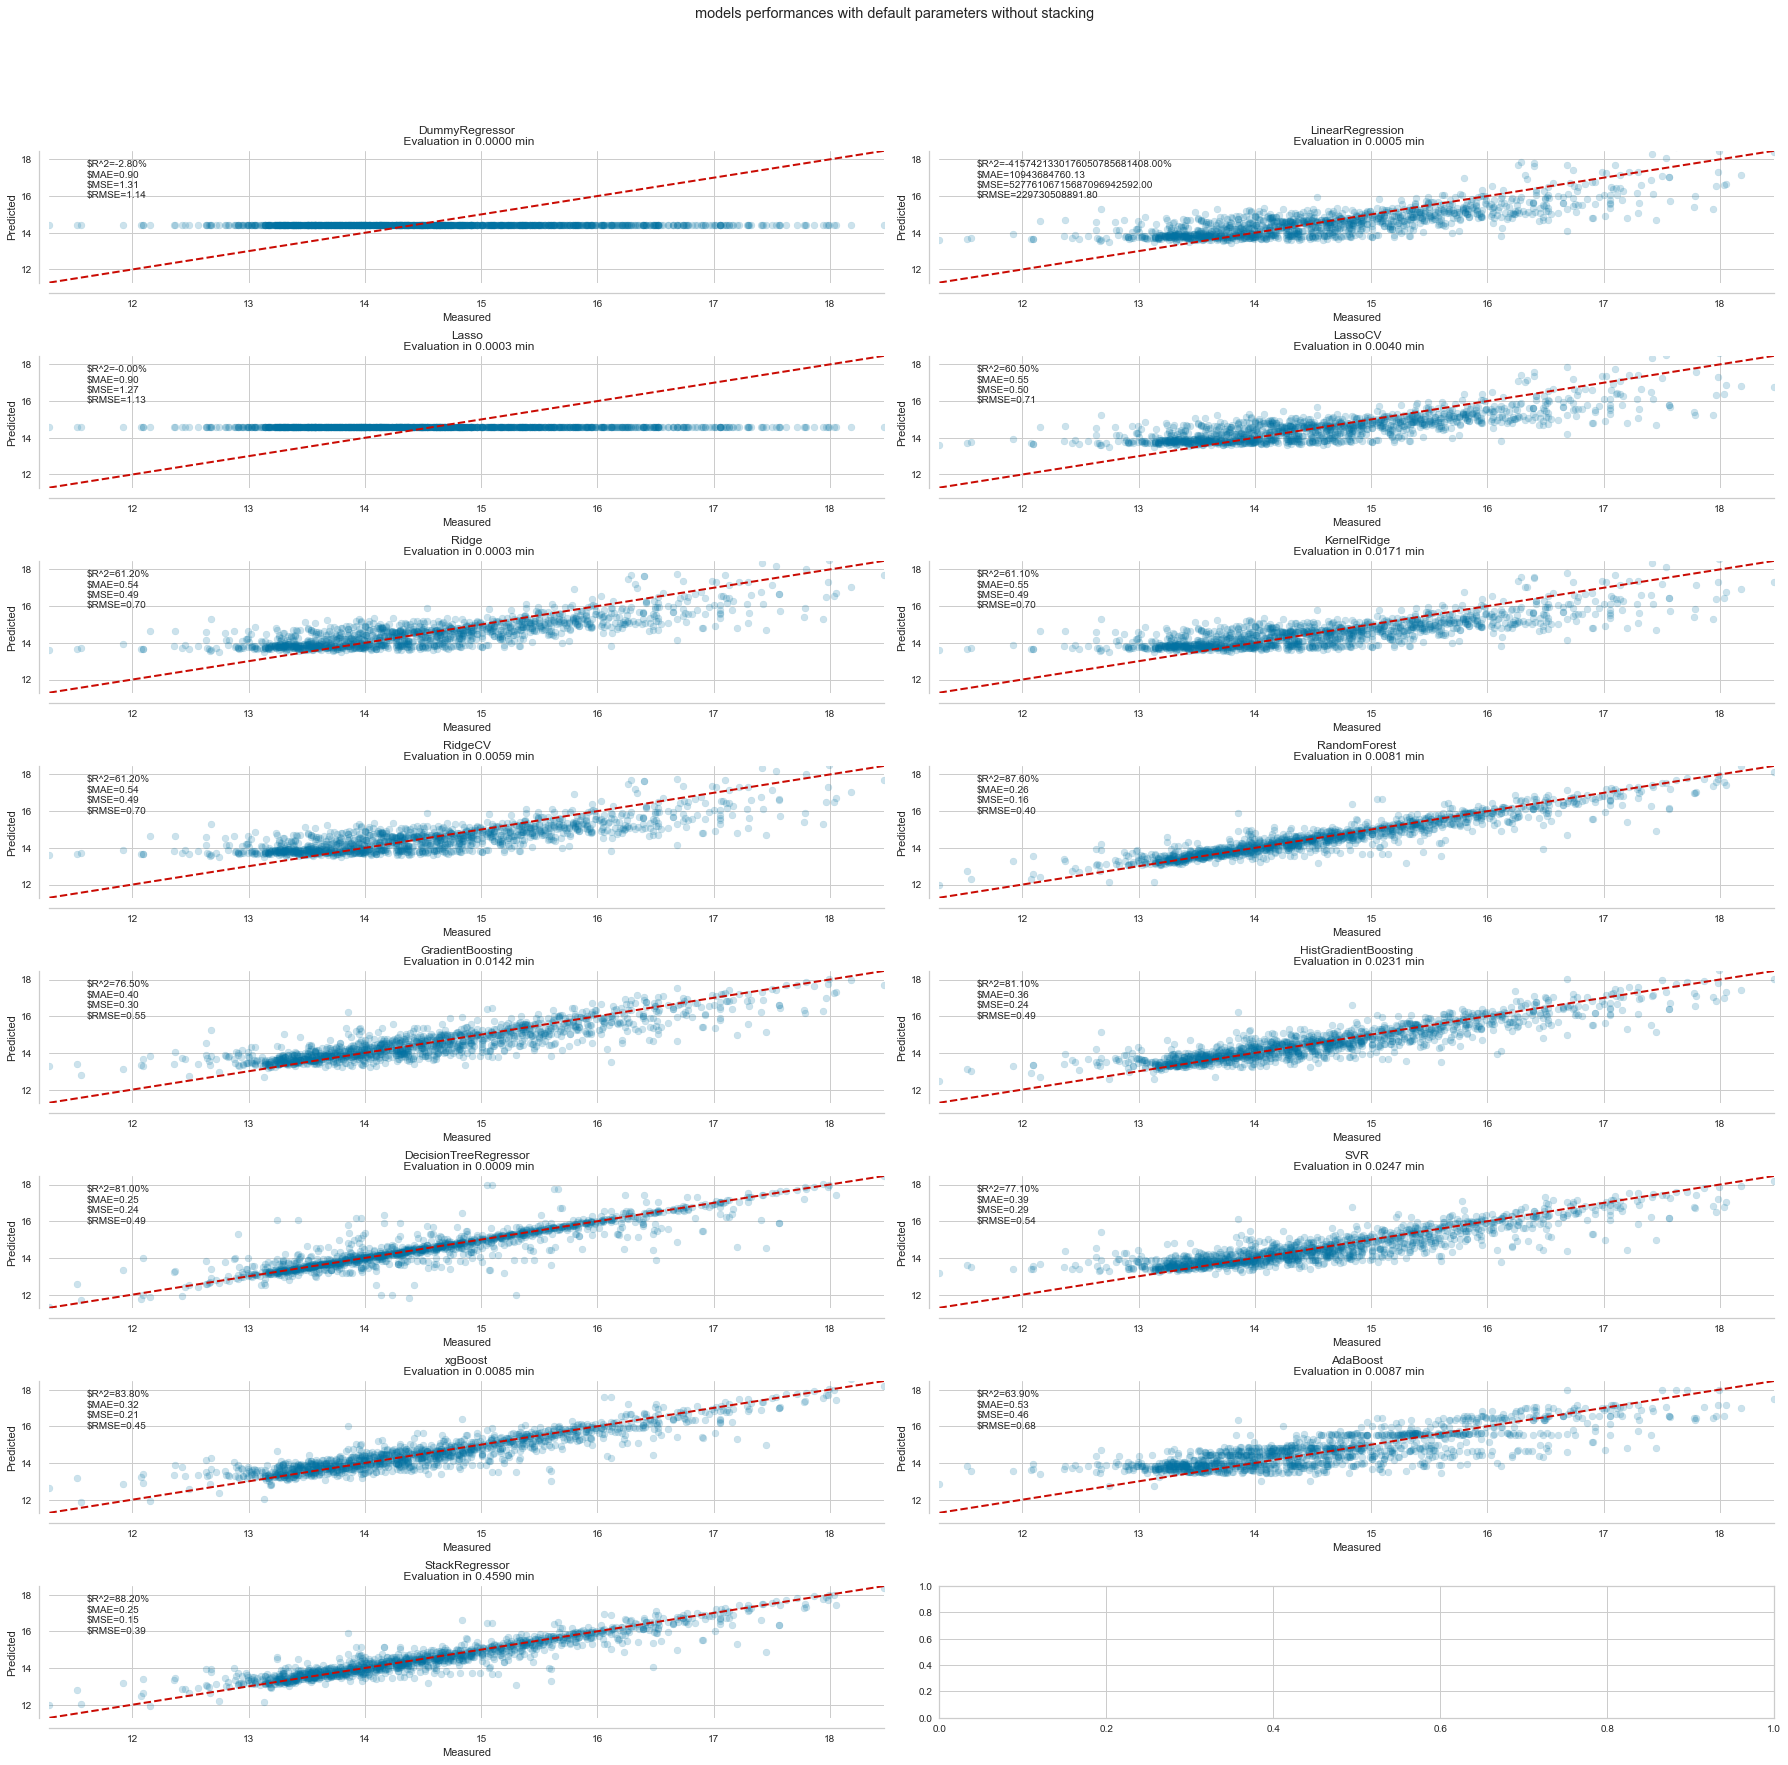

Evaluation des modèles avec des paramètres par défaut :


Dummy_R                       Linear_R   Lasso LassoCV  \
MAE                  0.895                10943684760.132   0.903   0.548   
MSE                  1.306      52776106715687096942592.0    1.27   0.502   
RMSE                 1.143            229730508891.803986   1.127   0.708   
R²(%)                -2.80  -4157421330176050785681408.00   -0.00   60.50   
elapsed_time (min)  0.0000                         0.0005  0.0003  0.0040   

                     Ridge Kernel  Ridge RidgeCV Random  Forest  \
MAE                  0.543         0.545   0.543           0.26   
MSE                  0.492         0.494   0.492          0.157   
RMSE                 0.701         0.703   0.701          0.396   
R²(%)                61.20         61.10   61.20          87.60   
elapsed_time (min)  0.0003        0.0171  0.0059         0.0081   

                   Gradient Boosting Hist Gradient Boosting  \
MAE                              0.4                  0.355   
MSE                            0.298                   0.24   
RMSE                           0.546                   0.49   
R²(%)                          76.50                  81.10   
elapsed_time (min)            0.0142                 0.0231   

                   Decision TreeRegressor     SVR xgBoost AdaBoost Stacking_R  
MAE                                 0.254   0.386   0.322    0.529      0.251  
MSE                                 0.242   0.291   0.205    0.458      0.149  
RMSE                                0.491    0.54   0.453    0.677      0.386  
R²(%)                               81.00   77.10   83.80    63.90      88.20  
elapsed_time (min)                 0.0009  0.0247  0.0085   0.0087     0.4590

In [41]:
####################### évaluation des modèles avec leurs paramètres par défaut sans cross-validation ##########################
# Appel de la fonction de calcul des performances des modèles avec les hyperparamètres par défaut
# (estimators, subplot_rows, subplot_columns, width_fig, height_fig)

models_perf_default_params (estimators + ST_reg,8,2,25,25)

# Affichage du tableau récapitulatif
print ("Evaluation des modèles avec des paramètres par défaut :")  
eval_model_default_parameters = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²(%)", "elapsed_time (min)"])
eval_model_default_parameters.columns = ["Dummy_R", "Linear_R", "Lasso","LassoCV","Ridge", "Kernel  Ridge", "RidgeCV", "Random  Forest", "Gradient Boosting", "Hist Gradient Boosting", "Decision TreeRegressor", "SVR", "xgBoost", "AdaBoost","Stacking_R"]    
eval_model_default_parameters   

On remarque que le stackingRegressor améliore la performance. Cependant, pour des raisons de lenteur d'éxecution 
du programme, le stacking ne sera pas retenu pour la suite de la modélisation.  

Afin d'optimiser le temps de traitement de la GridSearchCV, nous commençons d'abord par trouver les hyperparamètres avec la méthode RandomSearchCV. Cele-ci reste plus rapide que la GridSearchCV. RandomizedSearchCV va nous permettre de trouver dans un premier temps les meilleurs hyperparamètres pour chaque estimateur. L'idée est d'utiliser ensuite une GridSearchCV avec des intervales d'hyperparamètres autour de ceux proposés par la méthode précédente. Procéder ainsi va pouvoir réduire significativement le temps de traitement de la GridSearchCV.  

## Trouver les meilleurs hyperparamètres en appliquant une RandomizedSearchCV 

In [32]:
######################################### Utilisation de RandomizedSearchCV ###################################################
# Appel de la fonction RandomizedSearchCV : inputs = (estimators,parameters, n_iter, cv,scoring, random_state)

Random_search (estimators_GridSCV, params_list_RndSearchCV, 100, 5, 'neg_root_mean_squared_error', 42)




                                               Results from RandomizedSearchCV                                                
RandomForest  :  elapsed_time =  22.32  min

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=96, min_samples_leaf=2, n_estimators=350,
                      n_jobs=-1, random_state=42)

 RMSE =  0.4612

 The best parameters across ALL searched params:
 {'max_depth': 96, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 350}



                                               Results from RandomizedSearchCV                                                
GradientBoosting  :  elapsed_time =  33.27  min

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.05147875124998935, max_depth=8,
                          n_estimators=835, random_state=42,
                          subsample=0.9082658859666537)

 RMSE =  0.4146

 The best parameters across ALL searched params:
 {'learning_

## Affiner les meilleurs hyperparamètres proposés par la RandomSearchCV en appliquant une GridSearchCV 
 - Nous définissons des intervalles d'hyperparamètres sérés autour de la valeur trouvée par la RandomSearchCV. Ces  
   hyperparamètres sont listé dans "params_list"
 - Affichage des scores pour chaque modèle 
 - Le choix se fait selon deux critères : La RMSE la plus basse et le temps de traitement le plus bas. 
   (RMSE < 0.5 , Elapsed_time < 15 min)
 - Une fois le modèle choisi, on fait un bilan avant de le sauvegarder




                                               Results from GridsearchCV                                                
RandomForest  :  elapsed_time =  6.43  min

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=110, min_samples_leaf=2, n_estimators=500,
                      n_jobs=-1, random_state=42)

 RMSE =  0.4612

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 110, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}



                                               Results from GridsearchCV                                                
GradientBoosting  :  elapsed_time =  69.15  min

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.05, learning_rate=0.04, max_depth=8,
                          n_estimators=1000, random_state=42, subsample=0.8)

 RMSE =  0.4105

 The best parameters across ALL search

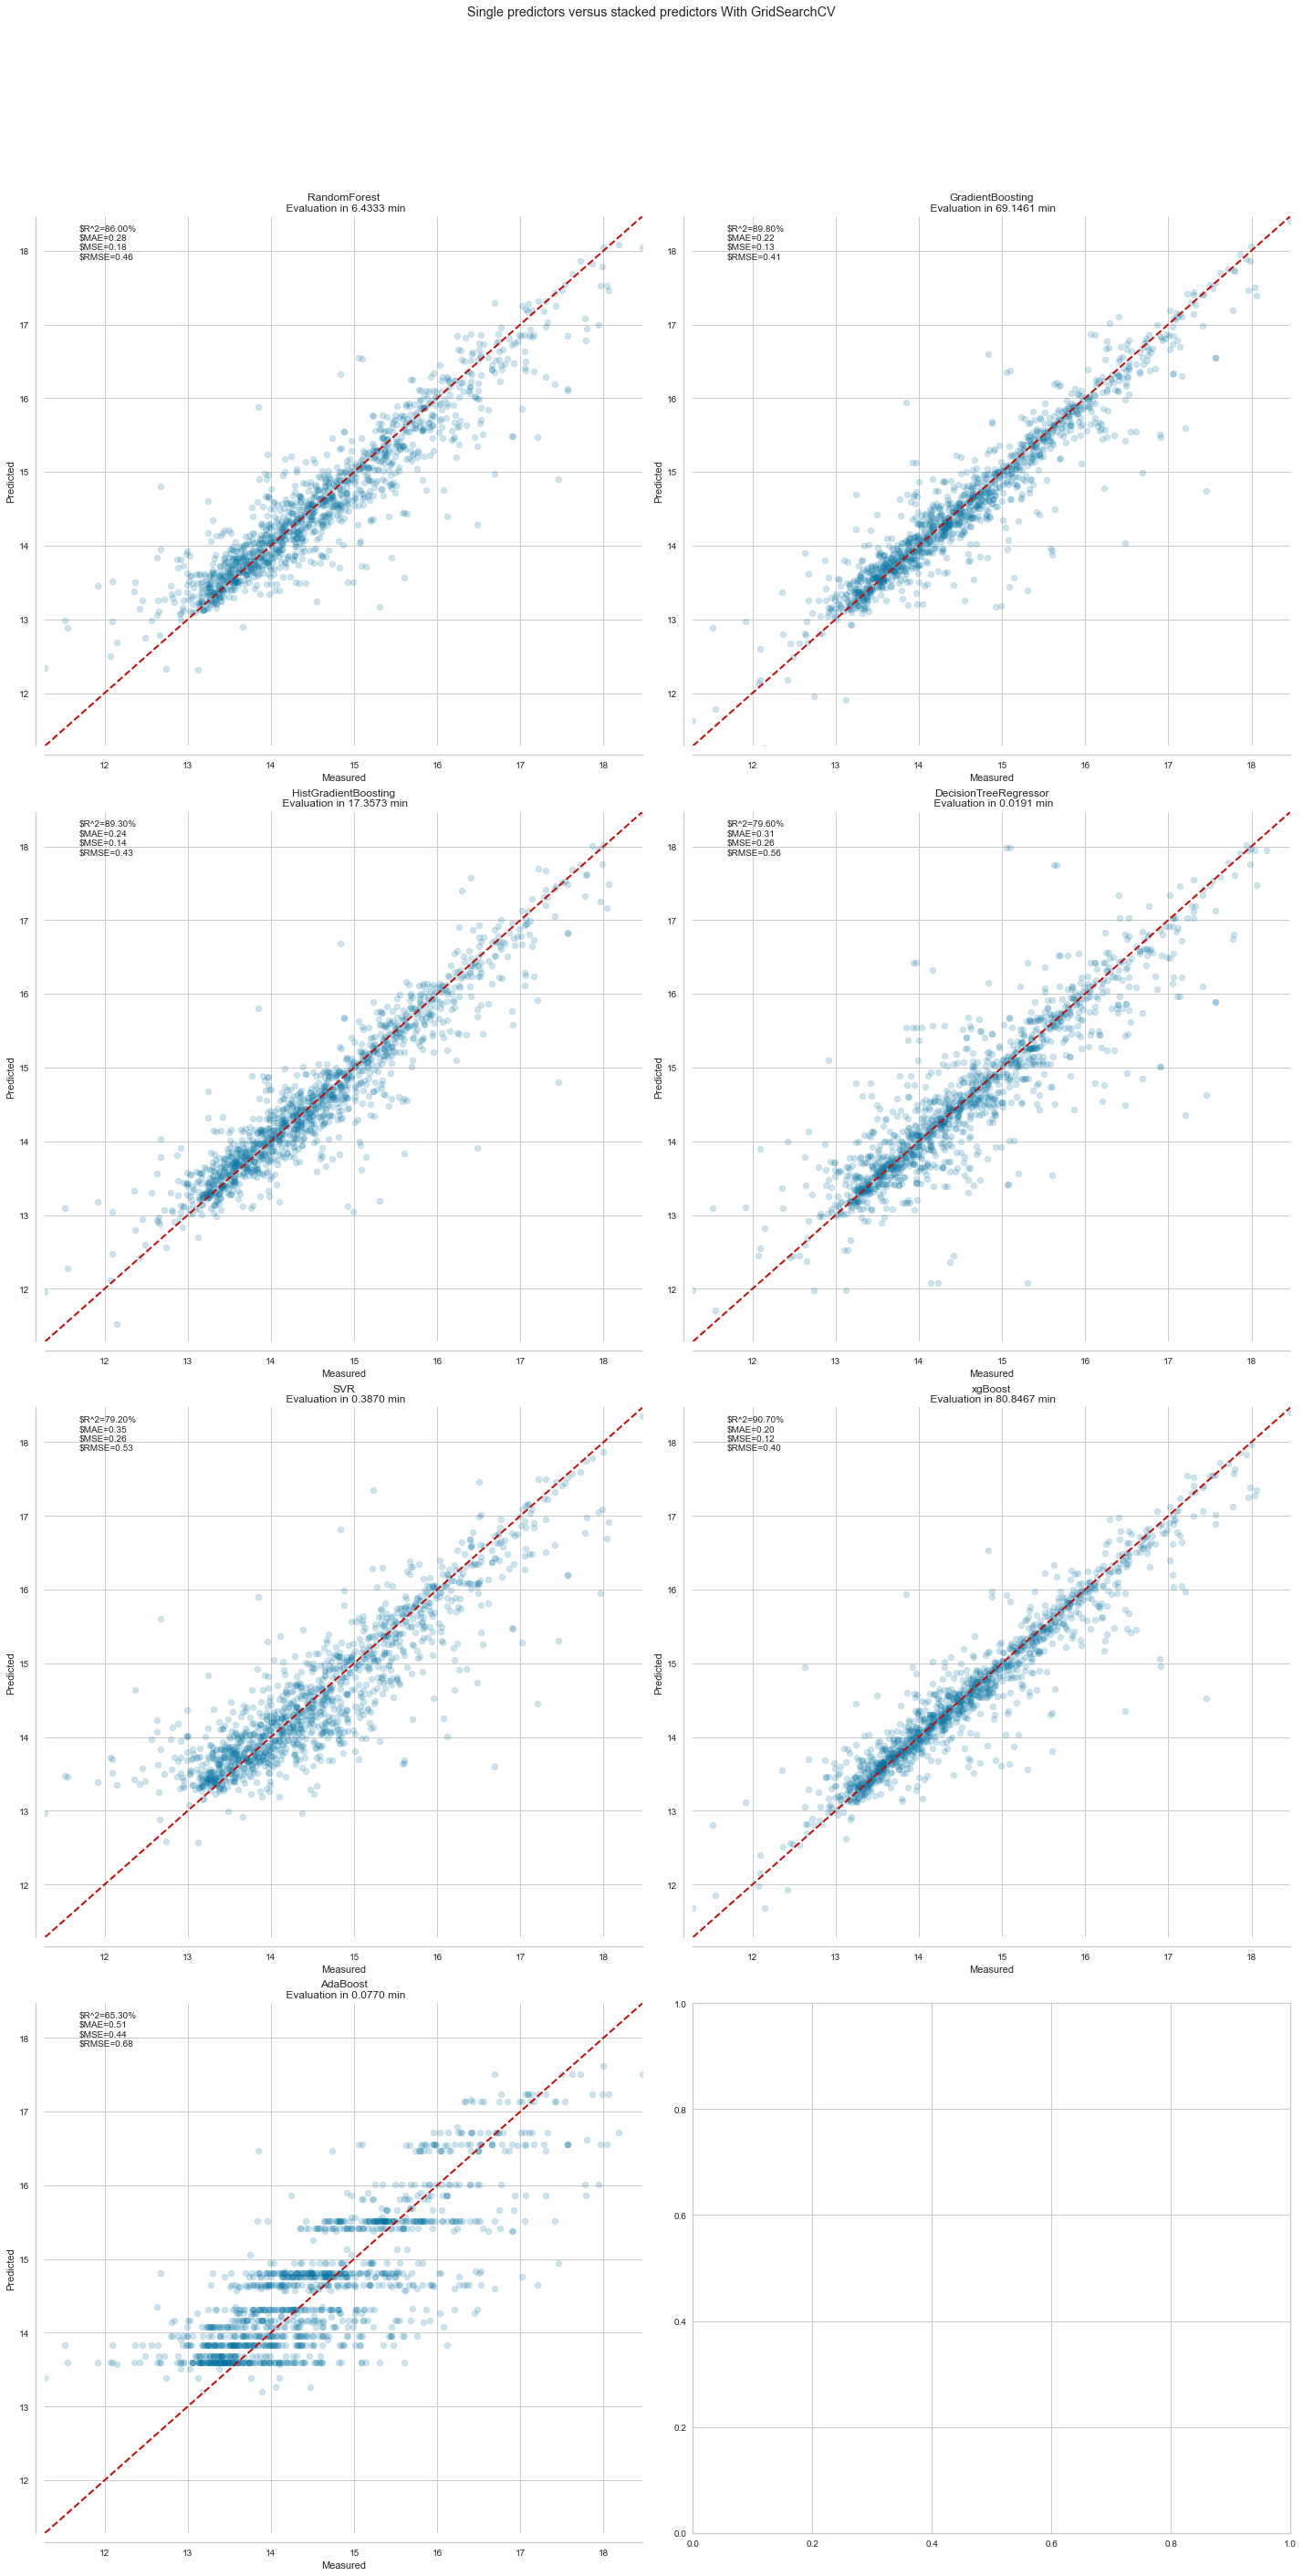

In [32]:
######################################### Utilisation de GridSearchCV ###################################################
# Appel de la fonction GridSearchCV : (estimators,parameters, cv,scoring,subplot_rows,subplot_columns,width_fig,height_fig):

Grid_Search (estimators_GridSCV, params_list, 5, 'neg_root_mean_squared_error', 4, 2, 20, 40)

In [33]:
# Affichage du tableau final
print("")
eval_GSCV_model = pd.DataFrame(dict_metrics_GSCV, index=["MAE (GridSearchCV)", "MSE (GridSearchCV)", "RMSE (GridSearchCV)", "R² (GridSearchCV)", "elapsed_time (min)"])
eval_GSCV_model.columns = ["RandomForest", "GradientBoosting", "HistGradientBoosting", "DecisionTreeRegressor", "SVR", "xgBoost", "AdaBoost"]   
print("===============================================================================================================================")    
print("                 According to business requirements, the best Algoritrhm to predict energy consumption is : \n"                 )
print("===============================================================================================================================")        
print(final_model)


                 According to business requirements, the best Algoritrhm to predict energy consumption is : 

RandomForestRegressor(max_depth=110, min_samples_leaf=2, n_estimators=500,
                      n_jobs=-1, random_state=42)


In [35]:
Tableau_final = pd.concat([eval_GSCV_model]) 
print ("\n Evaluation des modèles par défaut VS modèles avec leurs meilleurs hyperparamètres :")
Tableau_final


 Evaluation des modèles par défaut VS modèles avec leurs meilleurs hyperparamètres :


RandomForest GradientBoosting HistGradientBoosting  \
MAE (GridSearchCV)          0.28             0.22                 0.24   
MSE (GridSearchCV)          0.18             0.13                 0.14   
RMSE (GridSearchCV)        -0.46            -0.41                -0.43   
R² (GridSearchCV)          86.00            89.80                89.30   
elapsed_time (min)          6.43            69.15                17.36   

                    DecisionTreeRegressor    SVR xgBoost AdaBoost  
MAE (GridSearchCV)                   0.31   0.35    0.20     0.51  
MSE (GridSearchCV)                   0.26   0.26    0.12     0.44  
RMSE (GridSearchCV)                 -0.56  -0.53   -0.40    -0.68  
R² (GridSearchCV)                   79.60  79.20   90.70    65.30  
elapsed_time (min)                   0.02   0.39   80.85     0.08

##### Comme précisé précédement, le choix de ce modèle s'est fait sur la base de deux critères : 

- La RMSE  (<0.5)
- Le temps de traitement (<15 min)

Dans une configuration entreprise, le métier exigera soit plus de précision soit plus de rapidité de traitement. C'est en réalité cela qui conditionne le choix de l'algorithme. les métriques choisi ainsi que leur seuil a été fixé initialement pour garder que l'algorithme qui réponds aux exigences. 

## overfitting/underffiting checking

Notre modèle final (RandomForest) ne présente pas d'overfitting. les deux erreurs diminuent continuellement et l'écart entre le train_score et le validation_score est de 0.23.

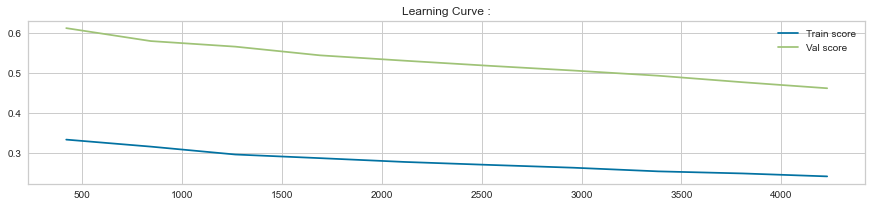

In [36]:
# Appel de la fonction évaludation des modèles  (model , X_train, y_train,X_test,cv,scoring)
evaluation (final_model, X_train, y_train, X_test, 5, 15, 3, 'neg_root_mean_squared_error') # neg_root_mean_squared_error

In [37]:
final_predictions_energy = final_model.predict(X_test)

In [38]:
calcul_metrics(np.array(y_test), final_predictions_energy)

MAE =  0.28296
MSE =  0.17739
RMSE =  0.42118
RMPSE =  0.10254
MAPE =  0.01936525640973651
R^2 =  0.86026


L'évaluation finale de notre modèle montre des scores plutôt bons. Notre modèle estime la consommation d'énergie avec une erreur de plus ou moins 0.10% (RMPSE). Il a un coefficient de détermination de 86%, c'est-à-dire qu'il permet d'expliquer 86% de la variance observée dans nos variables cibles. De plus, l'erreur moyenne est de 0.02% (MAPE). 

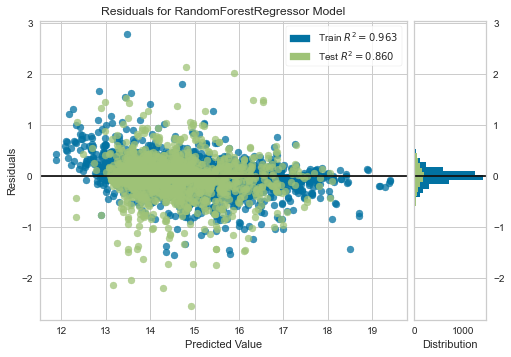

In [39]:
# Autre méthode de visualisation des résidus du modèle choisi " erreurs sur le train_set VS erreurs sur le test_set"
visualizer = ResidualsPlot(final_model)
visualizer.fit(np.array(X_train), np.array(y_train).reshape(5287,))
visualizer.score(np.array(X_test), np.array(y_test).reshape(1322,))
visualizer.show();

Les distributions des résidus du jeu d'entraînement et du jeu de test semblent suivre une loi normale. La distribution des résidus du jeu de test est plus aplatie. Cela peut s'expliquer par le nombre de données moins importants (seulement 20% de l'échantillon).


Erreurs de prédiction du modèle  RandomForestRegressor(max_depth=110, min_samples_leaf=2, n_estimators=500,
                      n_jobs=-1, random_state=42)  :


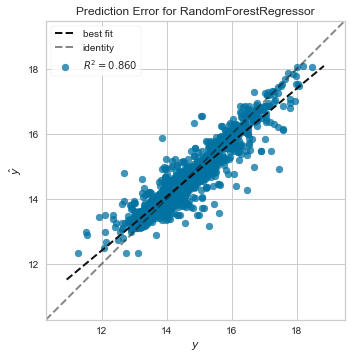

In [40]:
print("")
print("Erreurs de prédiction du modèle ",final_model," :")
visualizer = prediction_error(final_model, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));

L'analyse des erreurs de prédiction ne montre pas d'anomalie particulière dans notre modèle.Il sera enregistré dans un pipeline pour pouvoir le déployer.

In [111]:
coefficients=abs(final_model.feature_importances_)

In [120]:
pd.DataFrame(features, columns=['Variable'])

Variable
0               PrimaryPropertyType
1                 NumberofBuildings
2                    NumberofFloors
3                  PropertyGFATotal
4      SecondLargestPropertyUseType
5   SecondLargestPropertyUseTypeGFA
6       ThirdLargestPropertyUseType
7    ThirdLargestPropertyUseTypeGFA
8                               Age
9                           Parking
10                         Clusters

In [112]:
features=train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "ENERGYSTARScore", "YearBuilt","Neighborhood", "Latitude", "Longitude"], axis=1).columns


In [113]:
liste_coefs_rer=pd.concat((pd.DataFrame(features, columns=['Variable']),
                          pd.DataFrame(coefficients, columns=['Coefficient'])), axis=1).sort_values(by='Coefficient', ascending=False)

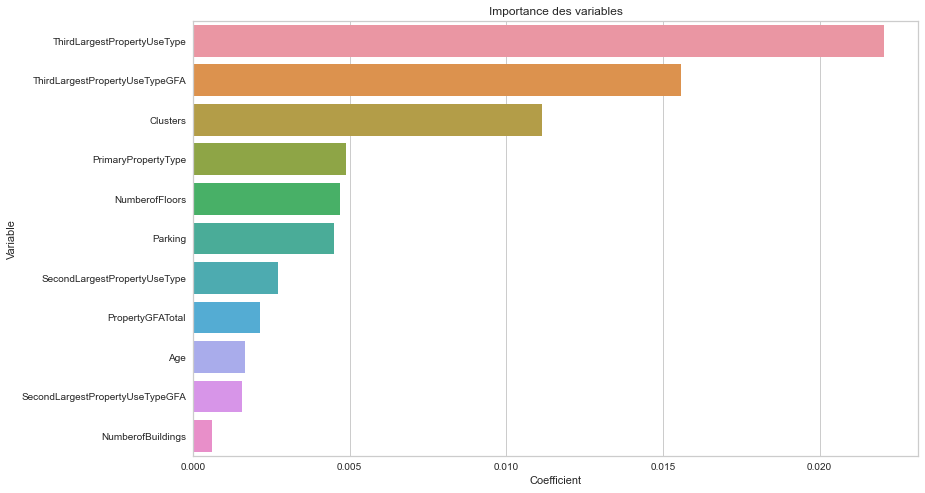

In [119]:
plt.figure(figsize=(13,8))
plt.title('Importance des variables')
sns.barplot(y=liste_coefs_rer['Variable'],
           x=liste_coefs_rer['Coefficient'])
plt.show()

L'analyse de l'importance des features montre que le type d'usage et sa superficie vont être des points importants de notre modèle. Il va s'agir des types d'usage tertiaire essentiellement. les clusters créer précédement grâce au features engineering sont finalement importants pour le modèle.

# Pipeline du modèle pour l'estimation de la consommation d'énergie

In [121]:
# création de pipeline contenant la transformation des variables et le modèle entraîné
# elle peut être utilisée pour faire des prédictions sur de nouvelles variables

full_pipeline_energy = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model)
])

# Prédiction des émissions de CO2
Pour la prédiction des émissions de CO, la méthode est la même que pour la prédiction de la consommation d'énergie. Cette fois-ci, la méthodologie ne sera pas aussi détaillé que pour la consommation d'énergie.

## Préparation des variables

In [123]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
# Stratification sur la variable "type de propriété"
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

X_train = train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "ENERGYSTARScore", "YearBuilt","Neighborhood", "Latitude", "Longitude"], axis=1)
y_train = train_set[["TotalGHGEmissions_log"]]

X_test = test_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions",  "ENERGYSTARScore", "YearBuilt","Neighborhood", "Latitude", "Longitude"], axis=1)
y_test = test_set[["TotalGHGEmissions_log"]]

# Appel fonction de calcul du pourcentage de : Train_set, test_set, y_test, y_train, X_test, y_test
pourcentage_train_test_set(data,train_set,test_set,X_test,y_test,X_train,y_train)


Dimensions du Train set: (5287, 12)
Pourcentage du train_set = (79.99697382357391, '% du dataset')

Dimensions du Test set: (1322, 12)
Pourcentage du test_set = (20.003026176426086, '% du dataset')

Dimensions du Y_train: (5287, 1)
Dimensions du  Y_test: (1322, 1)


La transformation des variables étant identiques à la méthode mise en place précédemment, on n'utilise le même pipeline. Cependant, ici il y aura un entraînement sur le nouveau jeu de données X_train pour que les imputations et autres transformations correspondent aux statistiques descriptives de cet échantillon.

In [124]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Création d'un modèle de base

In [125]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [126]:
y_pred = dummy_reg.predict(X_test)

In [127]:
calcul_metrics(np.array(y_test), y_pred)

MAE =  1.20974
MSE =  2.15842
RMSE =  1.46916
RMPSE =  1.36638
MAPE =  0.5438767301007326
R^2 =  -0.00023


### Evaluation des modèles avec leurs paramètres par défaut sans cross-validation : 
Sortie de 4 mesures : MAE, MSE, RMSE, R²
une métrique supplémentaire est ajoutée afin de mieux comparer la performance des modèles. Il s'agit du temps de traitement de chaque algorithme.

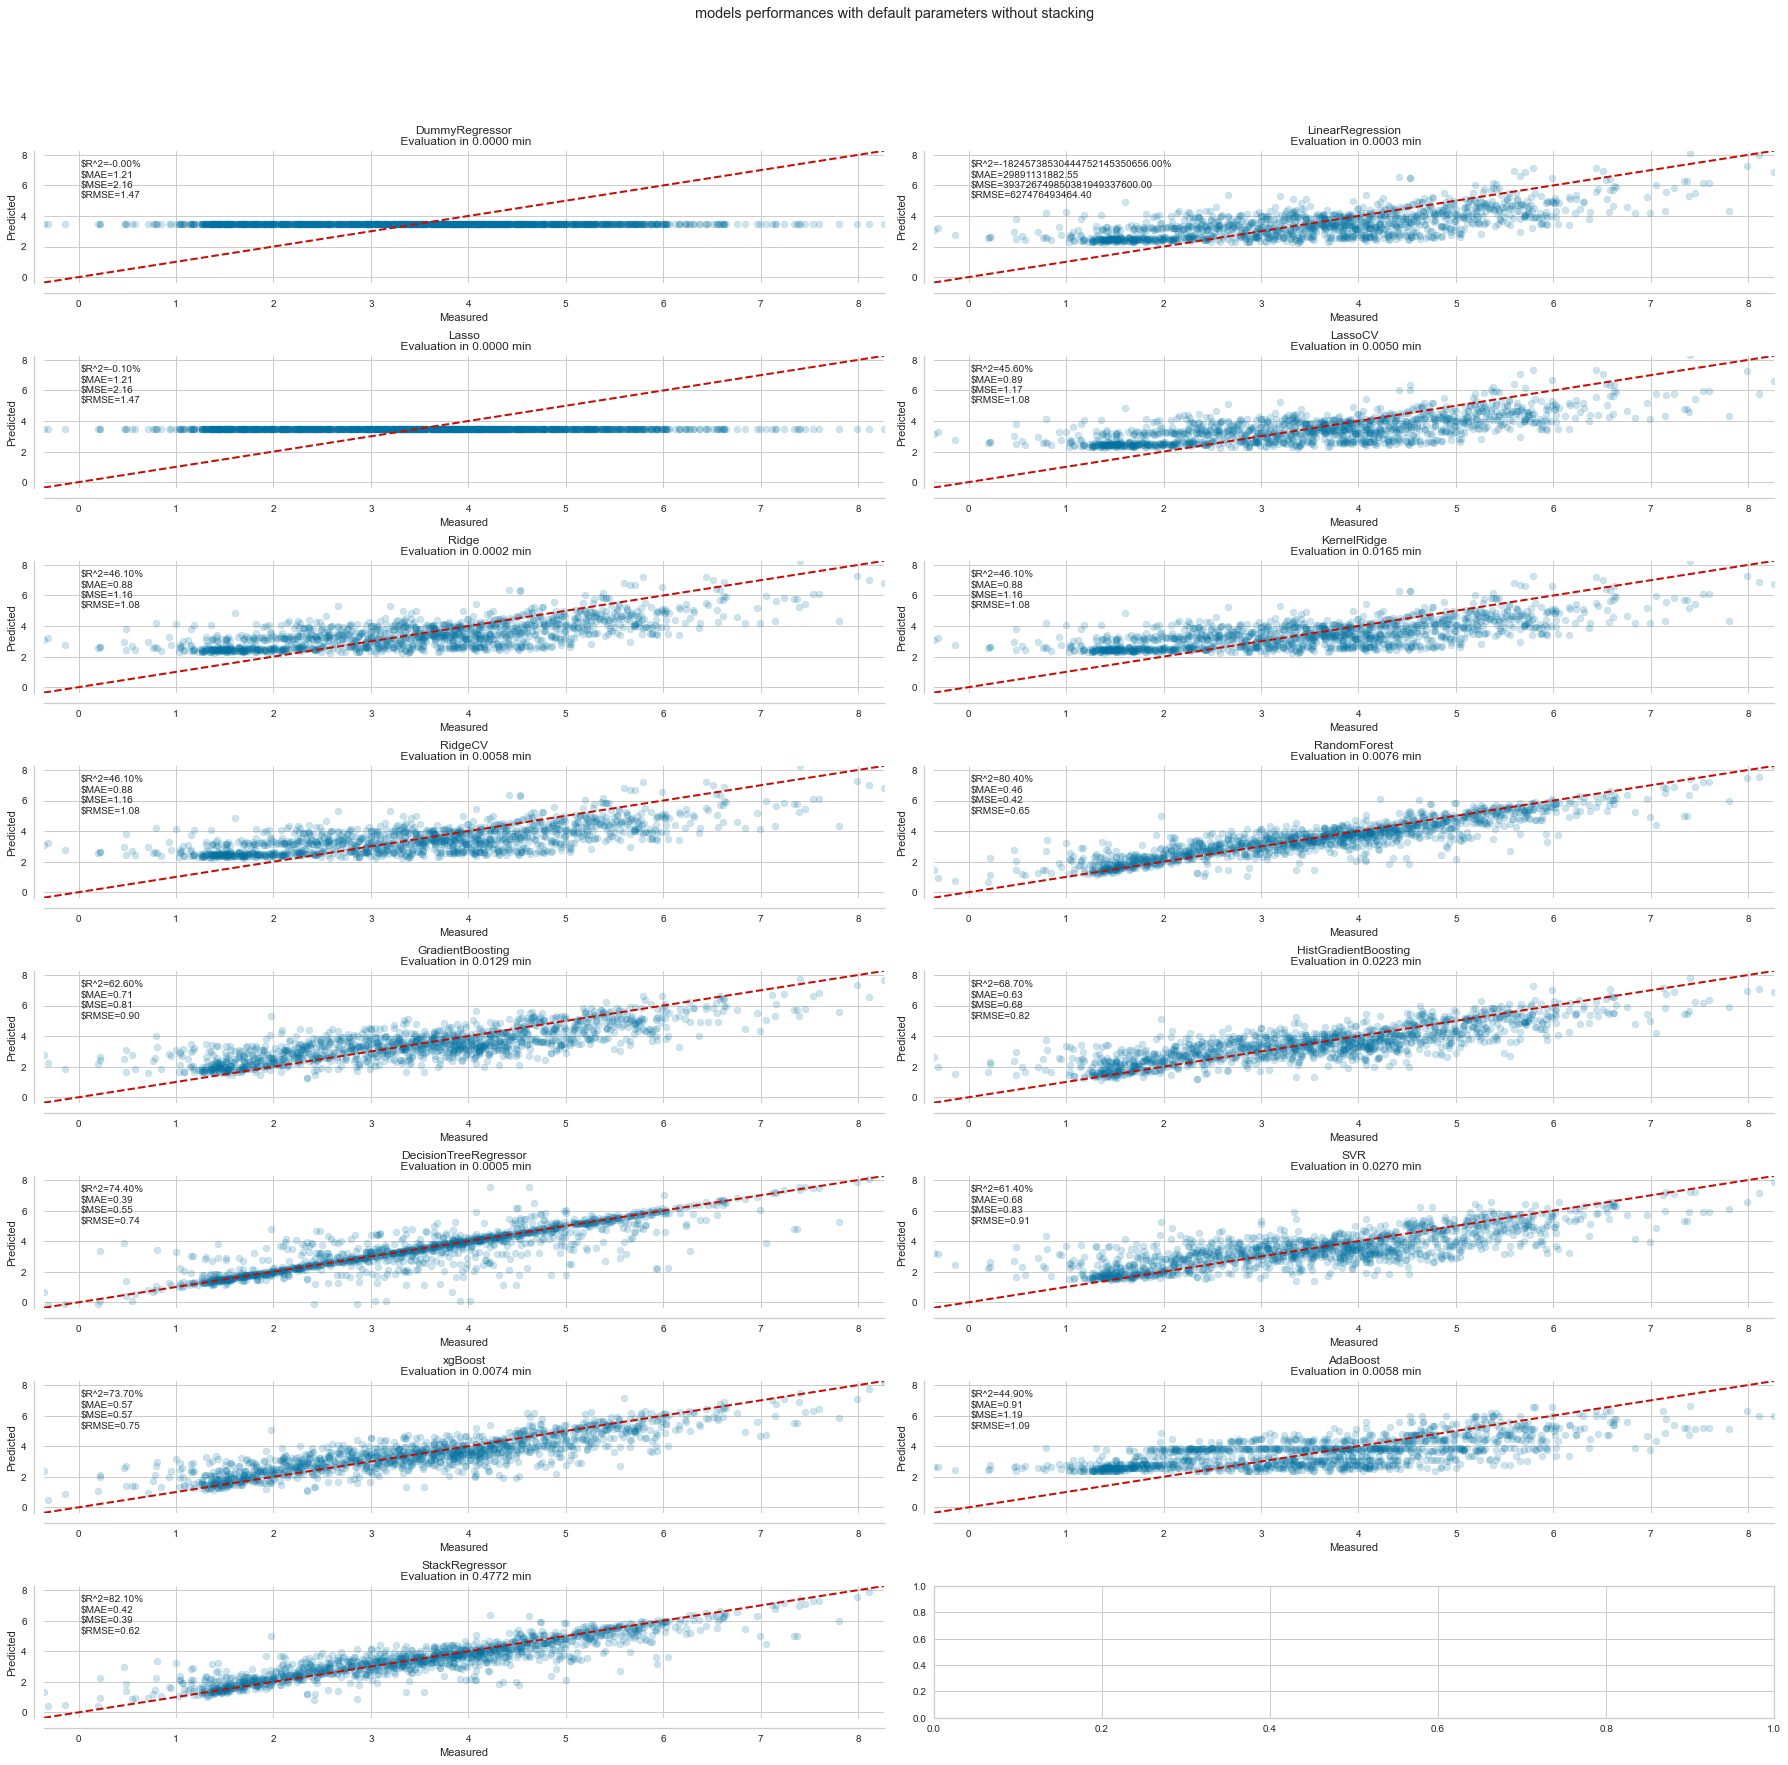

Evaluation des modèles avec des paramètres par défaut :


Dummy_R                        Linear_R   Lasso LassoCV  \
MAE                   1.21              29891131882.549999    1.21   0.885   
MSE                  2.158      393726749850381949337600.0    2.16   1.173   
RMSE                 1.469             627476493464.401978    1.47   1.083   
R²(%)                -0.00  -18245738530444752145350656.00   -0.10   45.60   
elapsed_time (min)  0.0000                          0.0003  0.0000  0.0050   

                     Ridge Kernel  Ridge RidgeCV Random  Forest  \
MAE                  0.883         0.883   0.883          0.463   
MSE                  1.163         1.163   1.163          0.422   
RMSE                 1.079         1.078   1.079           0.65   
R²(%)                46.10         46.10   46.10          80.40   
elapsed_time (min)  0.0002        0.0165  0.0058         0.0076   

                   Gradient Boosting Hist Gradient Boosting  \
MAE                            0.709                  0.633   
MSE                            0.806                  0.676   
RMSE                           0.898                  0.822   
R²(%)                          62.60                  68.70   
elapsed_time (min)            0.0129                 0.0223   

                   Decision TreeRegressor     SVR xgBoost AdaBoost Stacking_R  
MAE                                 0.393   0.683   0.566    0.912      0.424  
MSE                                 0.551   0.834   0.568     1.19      0.386  
RMSE                                0.743   0.913   0.754    1.091      0.622  
R²(%)                               74.40   61.40   73.70    44.90      82.10  
elapsed_time (min)                 0.0005  0.0270  0.0074   0.0058     0.4772

In [99]:
####################### évaluation des modèles avec leurs paramètres par défaut sans cross-validation ##########################
# Appel de la fonction de calcul des performances des modèles avec les hyperparamètres par défaut
# (estimators, subplot_rows, subplot_columns, width_fig, height_fig)

models_perf_default_params (estimators + ST_reg,8,2,25,25)

# Affichage du tableau récapitulatif
print ("Evaluation des modèles avec des paramètres par défaut :")  
eval_model_default_parameters = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²(%)", "elapsed_time (min)"])
eval_model_default_parameters.columns = ["Dummy_R", "Linear_R", "Lasso","LassoCV","Ridge", "Kernel  Ridge", "RidgeCV", "Random  Forest", "Gradient Boosting", "Hist Gradient Boosting", "Decision TreeRegressor", "SVR", "xgBoost", "AdaBoost","Stacking_R"]    
eval_model_default_parameters   

On remarque que le stackingRegressor améliore la performance. Cependant, pour des raisons de lenteur d'éxecution 
du programme, le stacking ne sera pas retenu pour la suite de la modélisation.  

Afin d'optimiser le temps de traitement de la GridSearchCV, nous commençons d'abord par trouver les hyperparamètres avec la méthode RandomSearchCV. Cele-ci reste plus rapide que la GridSearchCV. RandomizedSearchCV va nous permettre de trouver dans un premier temps les meilleurs hyperparamètres pour chaque estimateur. L'idée est d'utiliser ensuite une GridSearchCV avec des intervales d'hyperparamètres autour de ceux proposés par la méthode précédente. Procéder ainsi va pouvoir réduire significativement le temps de traitement de la GridSearchCV.  

### Trouver les meilleurs hyperparamètres en appliquant une RandomizedSearchCV 

In [105]:
######################################### Utilisation de RandomizedSearchCV ###################################################
# Appel de la fonction RandomizedSearchCV : inputs = (estimators,parameters, n_iter, cv,scoring, random_state)

Random_search (estimators_GridSCV, params_list_CO, 100, 5, 'neg_root_mean_squared_error', 42)




                                               Results from RandomizedSearchCV                                                
RandomForest  :  elapsed_time =  4.01  min

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=130, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=800, n_jobs=-1, random_state=42)

 RMSE =  0.7534

 The best parameters across ALL searched params:
 {'random_state': 42, 'n_jobs': -1, 'n_estimators': 800, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 130, 'bootstrap': True}



                                               Results from RandomizedSearchCV                                                
GradientBoosting  :  elapsed_time =  70.63  min

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.05, learning_rate=0.04, max_depth=10,
                          n_estimators=1000, random_state=42, subsample=0.8)

 RMSE =  0.6729

 The

### Affiner les meilleurs hyperparamètres proposés par la RandomSearchCV en appliquant une GridSearchCV 
 - Nous définissons des intervalles d'hyperparamètres sérés autour de la valeur trouvée par la RandomSearchCV. Ces  
   hyperparamètres sont listé dans "params_list"
 - Affichage des scores pour chaque modèle 
 - Le choix se fait selon deux critères : La RMSE la plus basse et le temps de traitement le plus bas. 
   (RMSE < 0.5 , Elapsed_time < 15 min)
 - Une fois le modèle choisi, on fait un bilan avant de le sauvegarder




                                               Results from GridsearchCV                                                
RandomForest  :  elapsed_time =  4.73  min

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=120, min_samples_leaf=2, n_estimators=700,
                      n_jobs=-1, random_state=42)

 RMSE =  0.7532

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 120, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700, 'n_jobs': -1, 'random_state': 42}



                                               Results from GridsearchCV                                                
GradientBoosting  :  elapsed_time =  57.42  min

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.05, learning_rate=0.04, max_depth=12,
                          n_estimators=1100, random_state=42, subsample=0.6)

 RMSE =  0.6722

 The best parameters across ALL searc

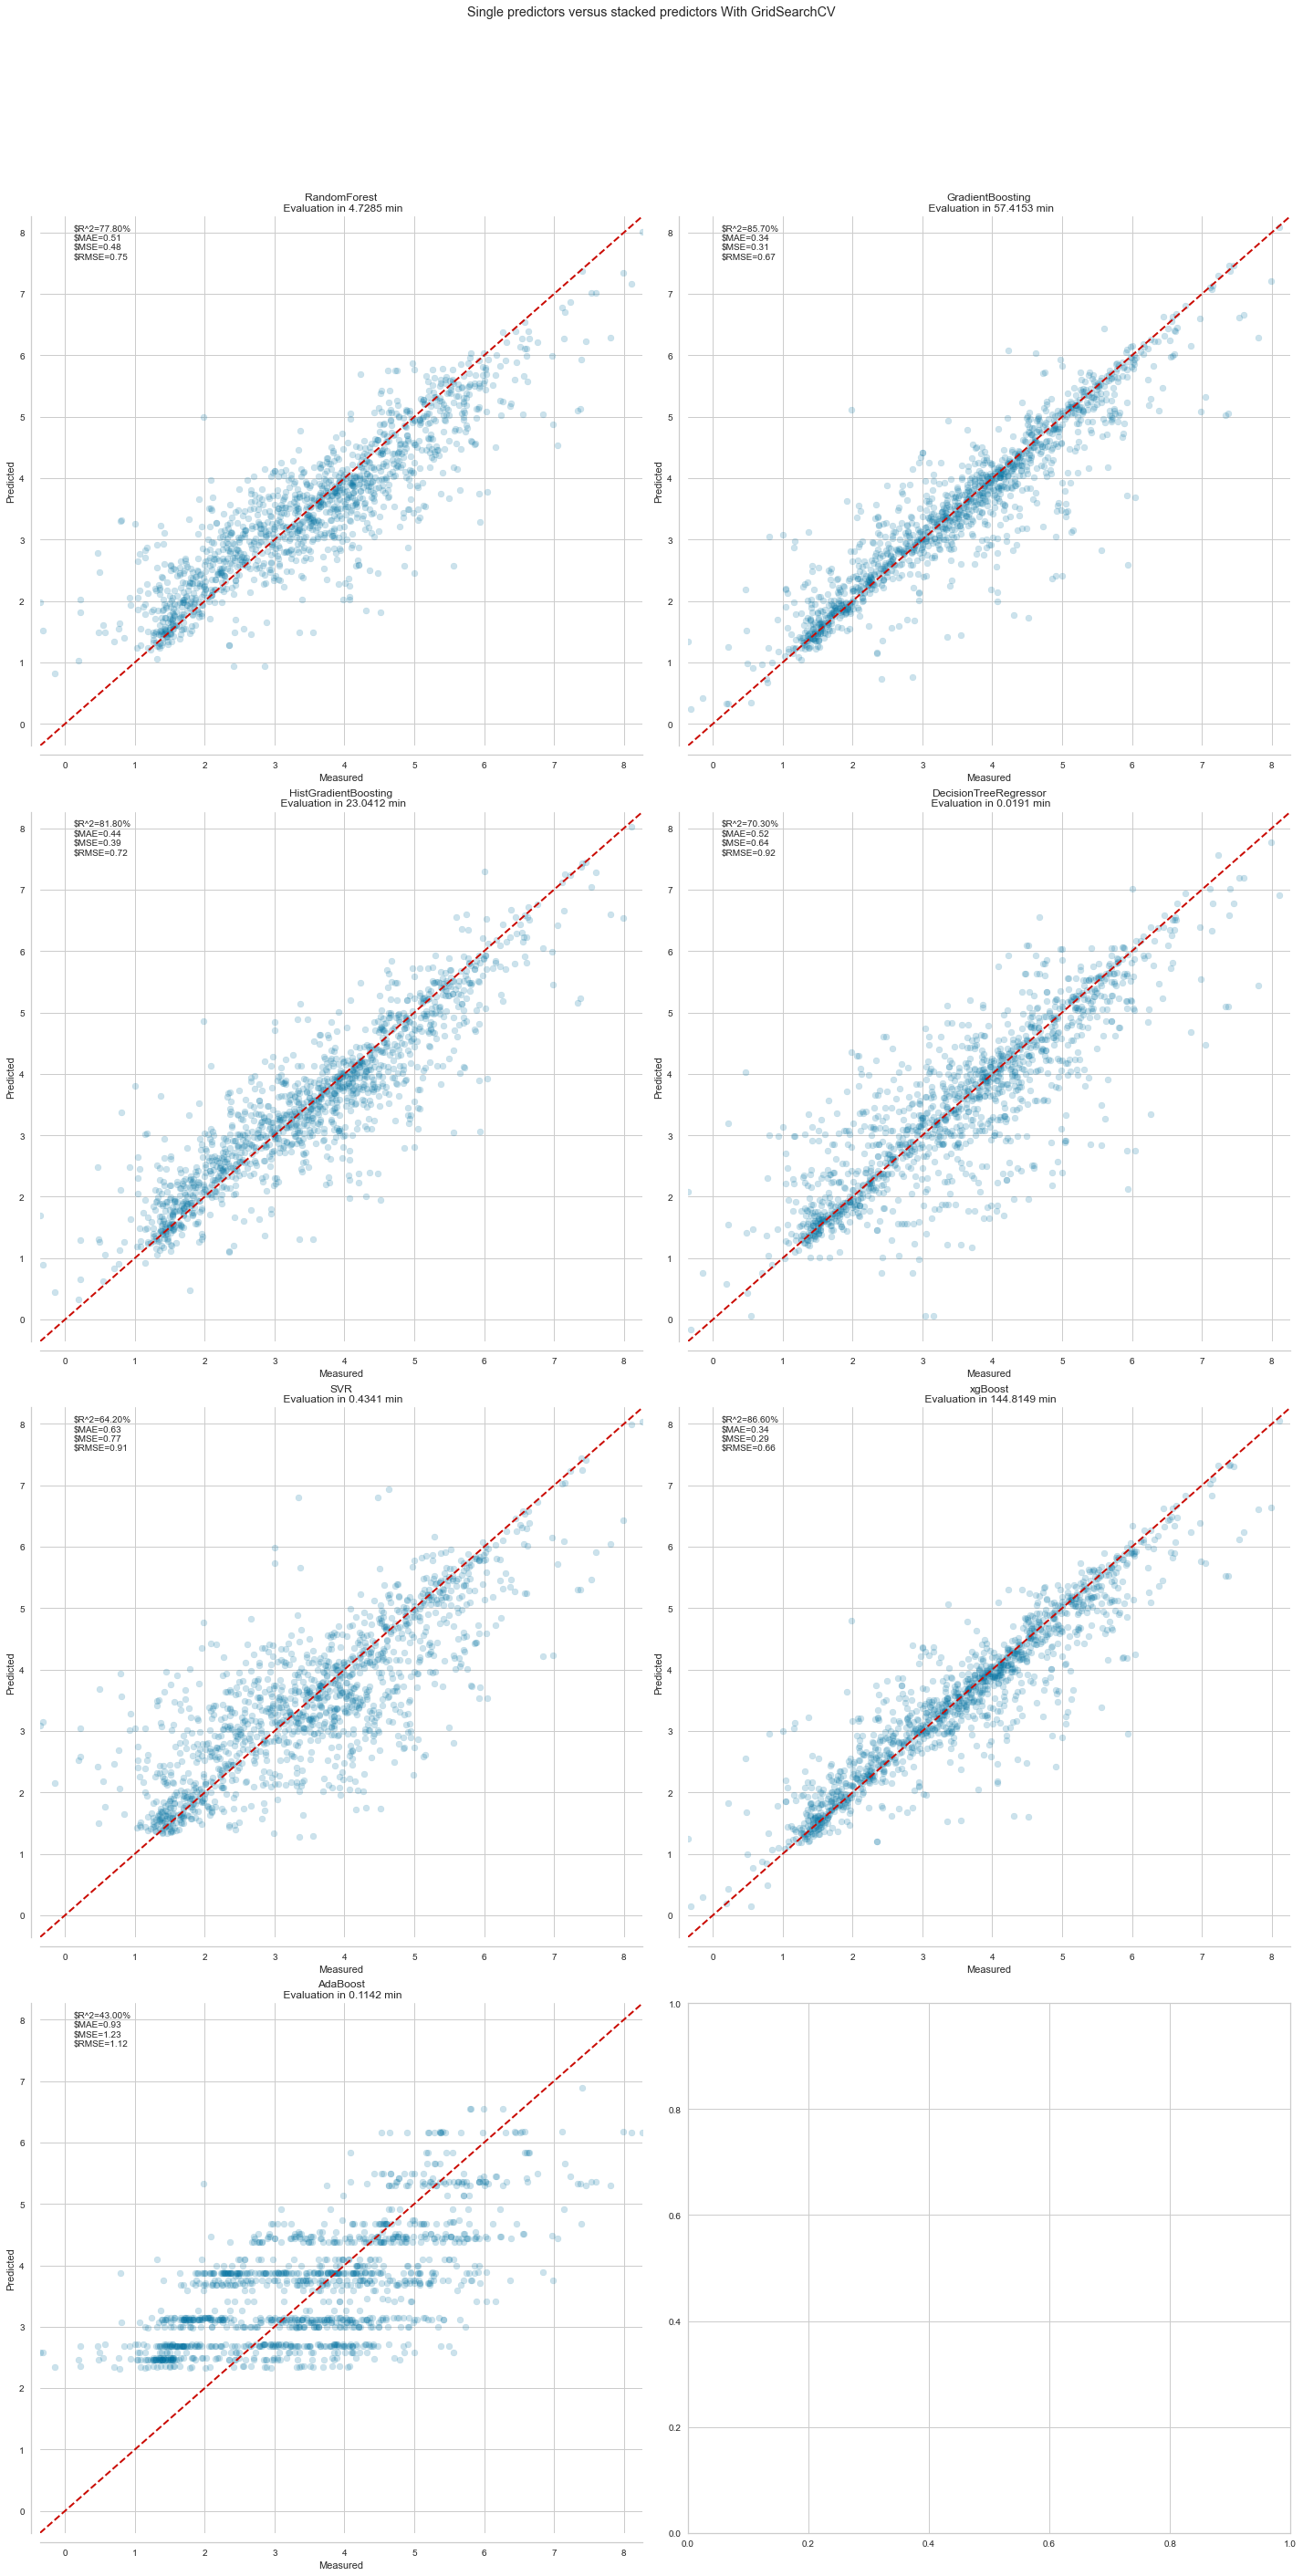

In [128]:
######################################### Utilisation de GridSearchCV ###################################################
# Appel de la fonction GridSearchCV : (estimators,parameters, cv,scoring,subplot_rows,subplot_columns,width_fig,height_fig):

Grid_Search (estimators_GridSCV, params_list_CO, 5, 'neg_root_mean_squared_error', 4, 2, 20, 40)

In [129]:
# Affichage du tableau final
print("")
eval_GSCV_model = pd.DataFrame(dict_metrics_GSCV, index=["MAE (GridSearchCV)", "MSE (GridSearchCV)", "RMSE (GridSearchCV)", "R² (GridSearchCV)", "elapsed_time (min)"])
eval_GSCV_model.columns = ["RandomForest", "GradientBoosting", "HistGradientBoosting", "DecisionTreeRegressor", "SVR", "xgBoost", "AdaBoost"]   
Tableau_final= pd.concat([eval_GSCV_model]) 
print("===============================================================================================================================")    
print("                 According to business requirements, the best Algoritrhm to predict energy consumption is : \n"                 )
print("===============================================================================================================================")        
print(final_model)


                 According to business requirements, the best Algoritrhm to predict energy consumption is : 

RandomForestRegressor(max_depth=120, min_samples_leaf=2, n_estimators=700,
                      n_jobs=-1, random_state=42)


### Le choix de ce modèle s'est fait sur la base de deux critères : 

- La RMSE la plus basse (<0.8)
- Le temps de traitement le plus bas (<15 min)

Dans une configuration entreprise, le métier exigera soit plus de précision soit plus de rapidité de traitement. C'est en réalité cela qui conditionne le choix de l'algorithme. les métriques choisi ainsi que leur seuil a été fixé initialement pour garder que l'algorithme qui réponds aux exigences. 

In [130]:
print ("\n Evaluation des modèles par défaut VS modèles avec leurs meilleurs hyperparamètres :")
Tableau_final


 Evaluation des modèles par défaut VS modèles avec leurs meilleurs hyperparamètres :


RandomForest GradientBoosting HistGradientBoosting  \
MAE (GridSearchCV)          0.51             0.34                 0.44   
MSE (GridSearchCV)          0.48             0.31                 0.39   
RMSE (GridSearchCV)        -0.75            -0.67                -0.72   
R² (GridSearchCV)          77.80            85.70                81.80   
elapsed_time (min)          4.73            57.42                23.04   

                    DecisionTreeRegressor    SVR xgBoost AdaBoost  
MAE (GridSearchCV)                   0.52   0.63    0.34     0.93  
MSE (GridSearchCV)                   0.64   0.77    0.29     1.23  
RMSE (GridSearchCV)                 -0.92  -0.91   -0.66    -1.12  
R² (GridSearchCV)                   70.30  64.20   86.60    43.00  
elapsed_time (min)                   0.02   0.43  144.81     0.11

### overfitting/underffiting checking

Notre modèle final (RandomForest) ne présente pas d'overfitting. les deux erreurs diminuent continuellement et l'écart entre le train_score et le validation_score est de 0.35.

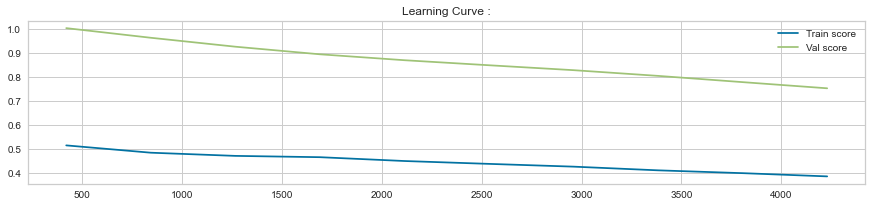

In [131]:
# Appel de la fonction évaludation des modèles  (model , X_train, y_train,X_test,cv,scoring)
evaluation (final_model, X_train, y_train, X_test, 5, 15, 3, 'neg_root_mean_squared_error') # neg_root_mean_squared_error

In [132]:
final_predictions_co2 = final_model.predict(X_test)

In [133]:
calcul_metrics(np.array(y_test), final_predictions_co2)

MAE =  0.50516
MSE =  0.47807
RMSE =  0.69143
RMPSE =  1.49673
MAPE =  0.21141868529607225
R^2 =  0.77846


L'évaluation finale de notre modèle montre des scores plutôt bons. Notre modèle estime l'emission de CO2 avec une erreur de plus ou moins 1.49%. Il a un coefficient de détermination de 78%, c'est-à-dire qu'il permet d'expliquer 78% de la variance observée dans nos variables cibles. De plus, l'erreur moyenne est de 0.21% (MAPE). 

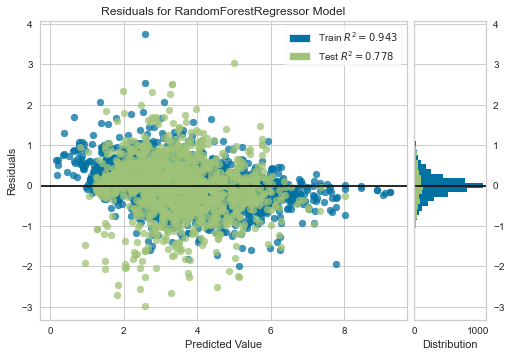

In [134]:
# Autre méthode de visualisation des résidus du modèle choisi " erreurs sur le train_set VS erreurs sur le test_set"
visualizer = ResidualsPlot(final_model)
visualizer.fit(np.array(X_train), np.array(y_train).reshape(5287,))
visualizer.score(np.array(X_test), np.array(y_test).reshape(1322,))
visualizer.show();

Les distributions des résidus du jeu d'entraînement et du jeu de test semblent suivre une loi normale. La distribution des résidus du jeu de test est plus aplatie. Cela peut s'expliquer par le nombre de données moins importants (seulement 20% de l'échantillon).


Erreurs de prédiction du modèle  RandomForestRegressor(max_depth=120, min_samples_leaf=2, n_estimators=700,
                      n_jobs=-1, random_state=42)  :


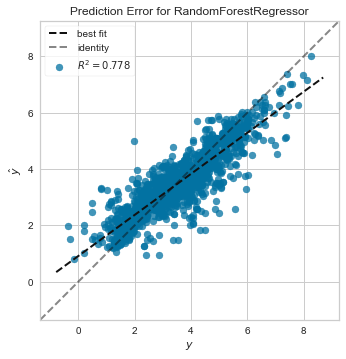

In [135]:
print("")
print("Erreurs de prédiction du modèle ",final_model," :")
visualizer = prediction_error(final_model, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));

L'analyse des erreurs de prédiction ne montre pas d'anomalie particulière dans notre modèle.Il sera enregistré dans un pipeline pour pouvoir le déployer.

# Feature importances

In [136]:
coefficients=abs(final_model.feature_importances_)

In [137]:
features=train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "ENERGYSTARScore", "YearBuilt","Neighborhood", "Latitude", "Longitude"], axis=1).columns

In [138]:
liste_coefs_rer=pd.concat((pd.DataFrame(features, columns=['Variable']),
                          pd.DataFrame(coefficients, columns=['Coefficient'])), axis=1).sort_values(by='Coefficient', ascending=False)

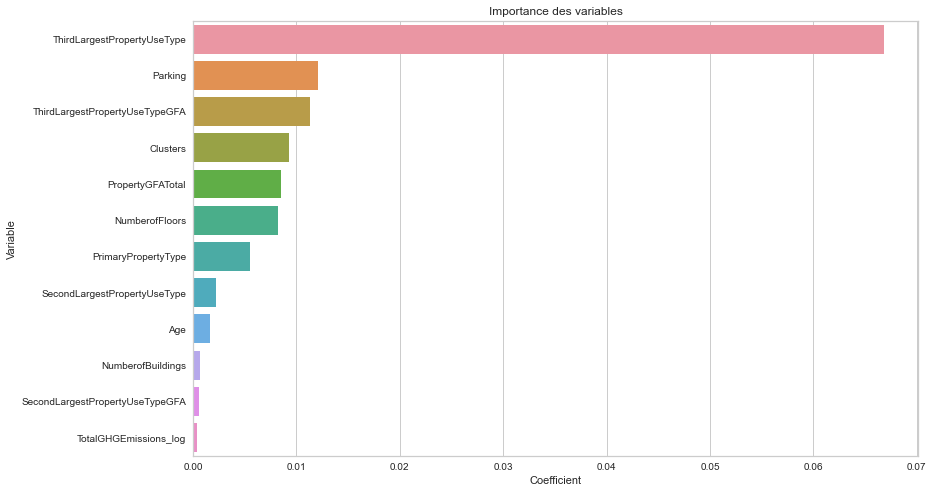

In [139]:
plt.figure(figsize=(13,8))
plt.title('Importance des variables')
sns.barplot(y=liste_coefs_rer['Variable'],
           x=liste_coefs_rer['Coefficient'])
plt.show()

L'analyse de l'importance des features montre que le type d'usage va être un des points importants de notre modèle. Il va s'agir des types d'usage secondaire ou tertiaire essentiellement. La présence d'un parking et la superficie de l'usage tertiaire vont avoir un rôle à jouer même si cela sera moins important.

# Pipeline du modèle pour l'estimation de l'émission de CO2

In [140]:
# création de pipeline contenant la transformation des variables et le modèle entraîné
# elle peut être utilisée pour faire des prédictions sur de nouvelles variables

full_pipeline_Co2 = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model)
])

# Prédiction emission de CO2 en ajoutant la variable "ENERGY STAR Score"

Nous allons voir si l'ajout de cette variable va améliorer notre modèle 

In [7]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
# Stratification sur la variable "type de propriété"
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

X_train = train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "YearBuilt","Neighborhood", "Latitude", "Longitude"], axis=1)
y_train = train_set[["TotalGHGEmissions_log"]]

X_test = test_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "YearBuilt","Neighborhood", "Latitude", "Longitude"], axis=1)
y_test = test_set[["TotalGHGEmissions_log"]]

# Appel fonction de calcul du pourcentage de : Train_set, test_set, y_test, y_train, X_test, y_test
pourcentage_train_test_set(data,train_set,test_set,X_test,y_test,X_train,y_train)

Dimensions du Train set: (5287, 13)
Pourcentage du train_set = (79.99697382357391, '% du dataset')

Dimensions du Test set: (1322, 13)
Pourcentage du test_set = (20.003026176426086, '% du dataset')

Dimensions du Y_train: (5287, 1)
Dimensions du  Y_test: (1322, 1)


In [8]:
# Séparation des variables catégorielles et numériques
cat_selector  = ["PrimaryPropertyType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "Parking"]
num_selector  = ["PropertyGFATotal","Age","Clusters", "NumberofBuildings", "NumberofFloors", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA","ENERGYSTARScore"]

In [9]:
# Création d'un pipeline de transformation
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])
num_pipe = Pipeline([('imputer', KNNImputer(n_neighbors=1)),('scaler', StandardScaler())])

In [10]:
preprocessor = ColumnTransformer(transformers=[('cat', cat_pipe, cat_selector),('num', num_pipe, num_selector)])

In [11]:
# transformation des variables
X_train = preprocessor.fit_transform(X_train)
X_test= preprocessor. transform(X_test)

print ("X test shape: ",X_test.shape)
print ("X train shape: ",X_train.shape)

X test shape:  (1322, 114)
X train shape:  (5287, 114)


# Création d'un modèle de base

In [12]:
# On créer le modèle naîf "médiane"
dummy_reg = DummyRegressor(strategy="median")

# On entraine le modèle naîf sur les données d'entrainement
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

### Evaludation du modèle avec le jeu de test 

In [13]:
# Evaluation du modèle naîf
y_pred = dummy_reg.predict(X_test)
calcul_metrics(np.array(y_test), y_pred)

MAE =  1.20974
MSE =  2.15842
RMSE =  1.46916
RMPSE =  1.36638
MAPE =  0.5438767301007326
R^2 =  -0.00023


## Mesure de performances Multi-prédicteurs y compris le stacking

### Evaluation des modèles avec leurs paramètres par défaut sans cross-validation 

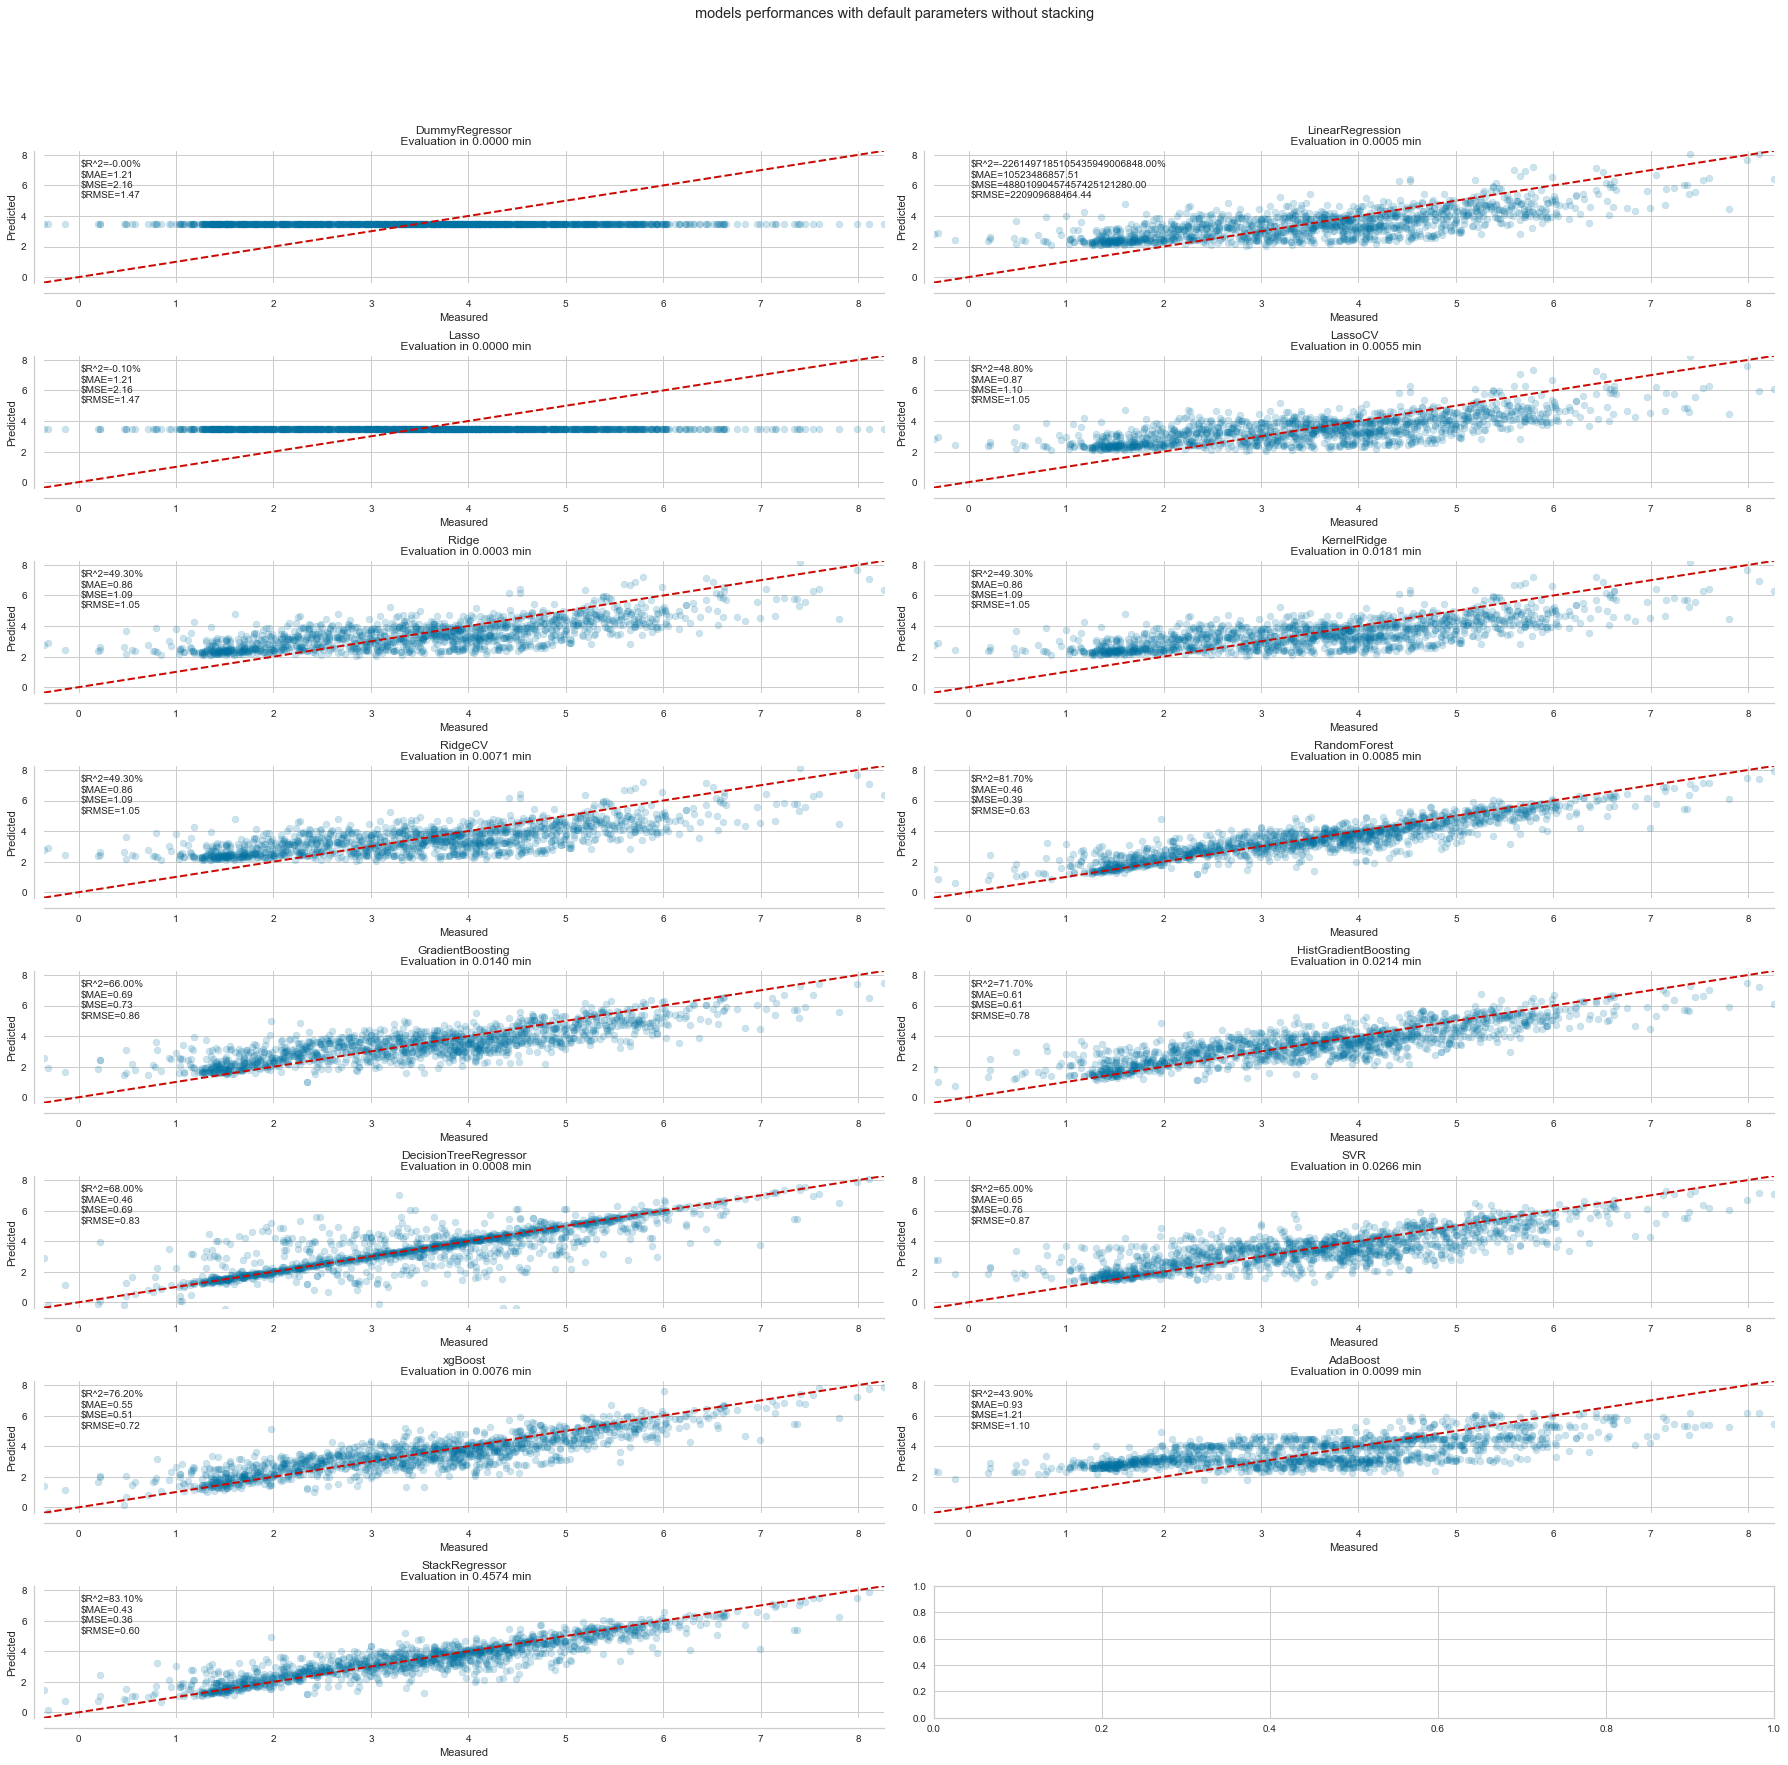

Evaluation des modèles avec des paramètres par défaut :


Dummy_R                       Linear_R   Lasso LassoCV  \
MAE                   1.21                10523486857.511    1.21   0.866   
MSE                  2.158      48801090457457425121280.0    2.16   1.105   
RMSE                 1.469            220909688464.442993    1.47   1.051   
R²(%)                -0.00  -2261497185105435949006848.00   -0.10   48.80   
elapsed_time (min)  0.0000                         0.0005  0.0000  0.0055   

                     Ridge Kernel  Ridge RidgeCV Random  Forest  \
MAE                  0.864         0.864   0.864          0.463   
MSE                  1.094         1.094   1.094          0.395   
RMSE                 1.046         1.046   1.046          0.628   
R²(%)                49.30         49.30   49.30          81.70   
elapsed_time (min)  0.0003        0.0181  0.0071         0.0085   

                   Gradient Boosting Hist Gradient Boosting  \
MAE                            0.687                  0.611   
MSE                            0.735                  0.611   
RMSE                           0.857                  0.782   
R²(%)                          66.00                  71.70   
elapsed_time (min)            0.0140                 0.0214   

                   Decision TreeRegressor     SVR xgBoost AdaBoost Stacking_R  
MAE                                 0.464   0.649   0.546    0.933      0.426  
MSE                                  0.69   0.755   0.514     1.21      0.364  
RMSE                                0.831   0.869   0.717      1.1      0.603  
R²(%)                               68.00   65.00   76.20    43.90      83.10  
elapsed_time (min)                 0.0008  0.0266  0.0076   0.0099     0.4574

In [14]:
####################### évaluation des modèles avec leurs paramètres par défaut sans cross-validation ##########################
# Appel de la fonction de calcul des performances des modèles avec les hyperparamètres par défaut
# (estimators, subplot_rows, subplot_columns, width_fig, height_fig)

models_perf_default_params (estimators + ST_reg,8,2,25,25)

# Affichage du tableau récapitulatif
print ("Evaluation des modèles avec des paramètres par défaut :")  
eval_model_default_parameters = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²(%)", "elapsed_time (min)"])
eval_model_default_parameters.columns = ["Dummy_R", "Linear_R", "Lasso","LassoCV","Ridge", "Kernel  Ridge", "RidgeCV", "Random  Forest", "Gradient Boosting", "Hist Gradient Boosting", "Decision TreeRegressor", "SVR", "xgBoost", "AdaBoost","Stacking_R"]    
eval_model_default_parameters   

### Trouver les meilleurs hyperparamètres en appliquant une RandomizedSearchCV¶

In [15]:
######################################### Utilisation de RandomizedSearchCV ###################################################
# Appel de la fonction RandomizedSearchCV : inputs = (estimators,parameters, n_iter, cv,scoring, random_state)

Random_search (estimators_GridSCV, params_list_CO, 100, 5, 'neg_root_mean_squared_error', 42)




                                               Results from RandomizedSearchCV                                                
RandomForest  :  elapsed_time =  4.70  min

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=120, min_samples_leaf=2, n_estimators=700,
                      n_jobs=-1, random_state=42)

 RMSE =  0.7514

 The best parameters across ALL searched params:
 {'random_state': 42, 'n_jobs': -1, 'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 120, 'bootstrap': True}



                                               Results from RandomizedSearchCV                                                
GradientBoosting  :  elapsed_time =  58.20  min

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.05, learning_rate=0.04, max_depth=8,
                          n_estimators=1100, random_state=42, subsample=0.6)

 RMSE =  0.6689

 The best parameters acros

## Affiner les meilleurs hyperparamètres proposés par la RandomSearchCV en appliquant une GridSearchCV 
 - Nous définissons des intervalles d'hyperparamètres sérés autour de la valeur trouvée par la RandomSearchCV. Ces  
   hyperparamètres sont listé dans "params_list"
 - Affichage des scores pour chaque modèle 
 - Le choix se fait selon deux critères : La RMSE la plus basse et le temps de traitement le plus bas. 
   (RMSE < 0.5 , Elapsed_time < 15 min)
 - Une fois le modèle choisi, on fait un bilan avant de le sauvegarder




                                               Results from GridsearchCV                                                
RandomForest  :  elapsed_time =  4.65  min

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=120, min_samples_leaf=2, n_estimators=700,
                      n_jobs=-1, random_state=42)

 RMSE =  0.7514

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 120, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700, 'n_jobs': -1, 'random_state': 42}



                                               Results from GridsearchCV                                                
GradientBoosting  :  elapsed_time =  58.09  min

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.05, learning_rate=0.04, max_depth=8,
                          n_estimators=1100, random_state=42, subsample=0.6)

 RMSE =  0.6689

 The best parameters across ALL search

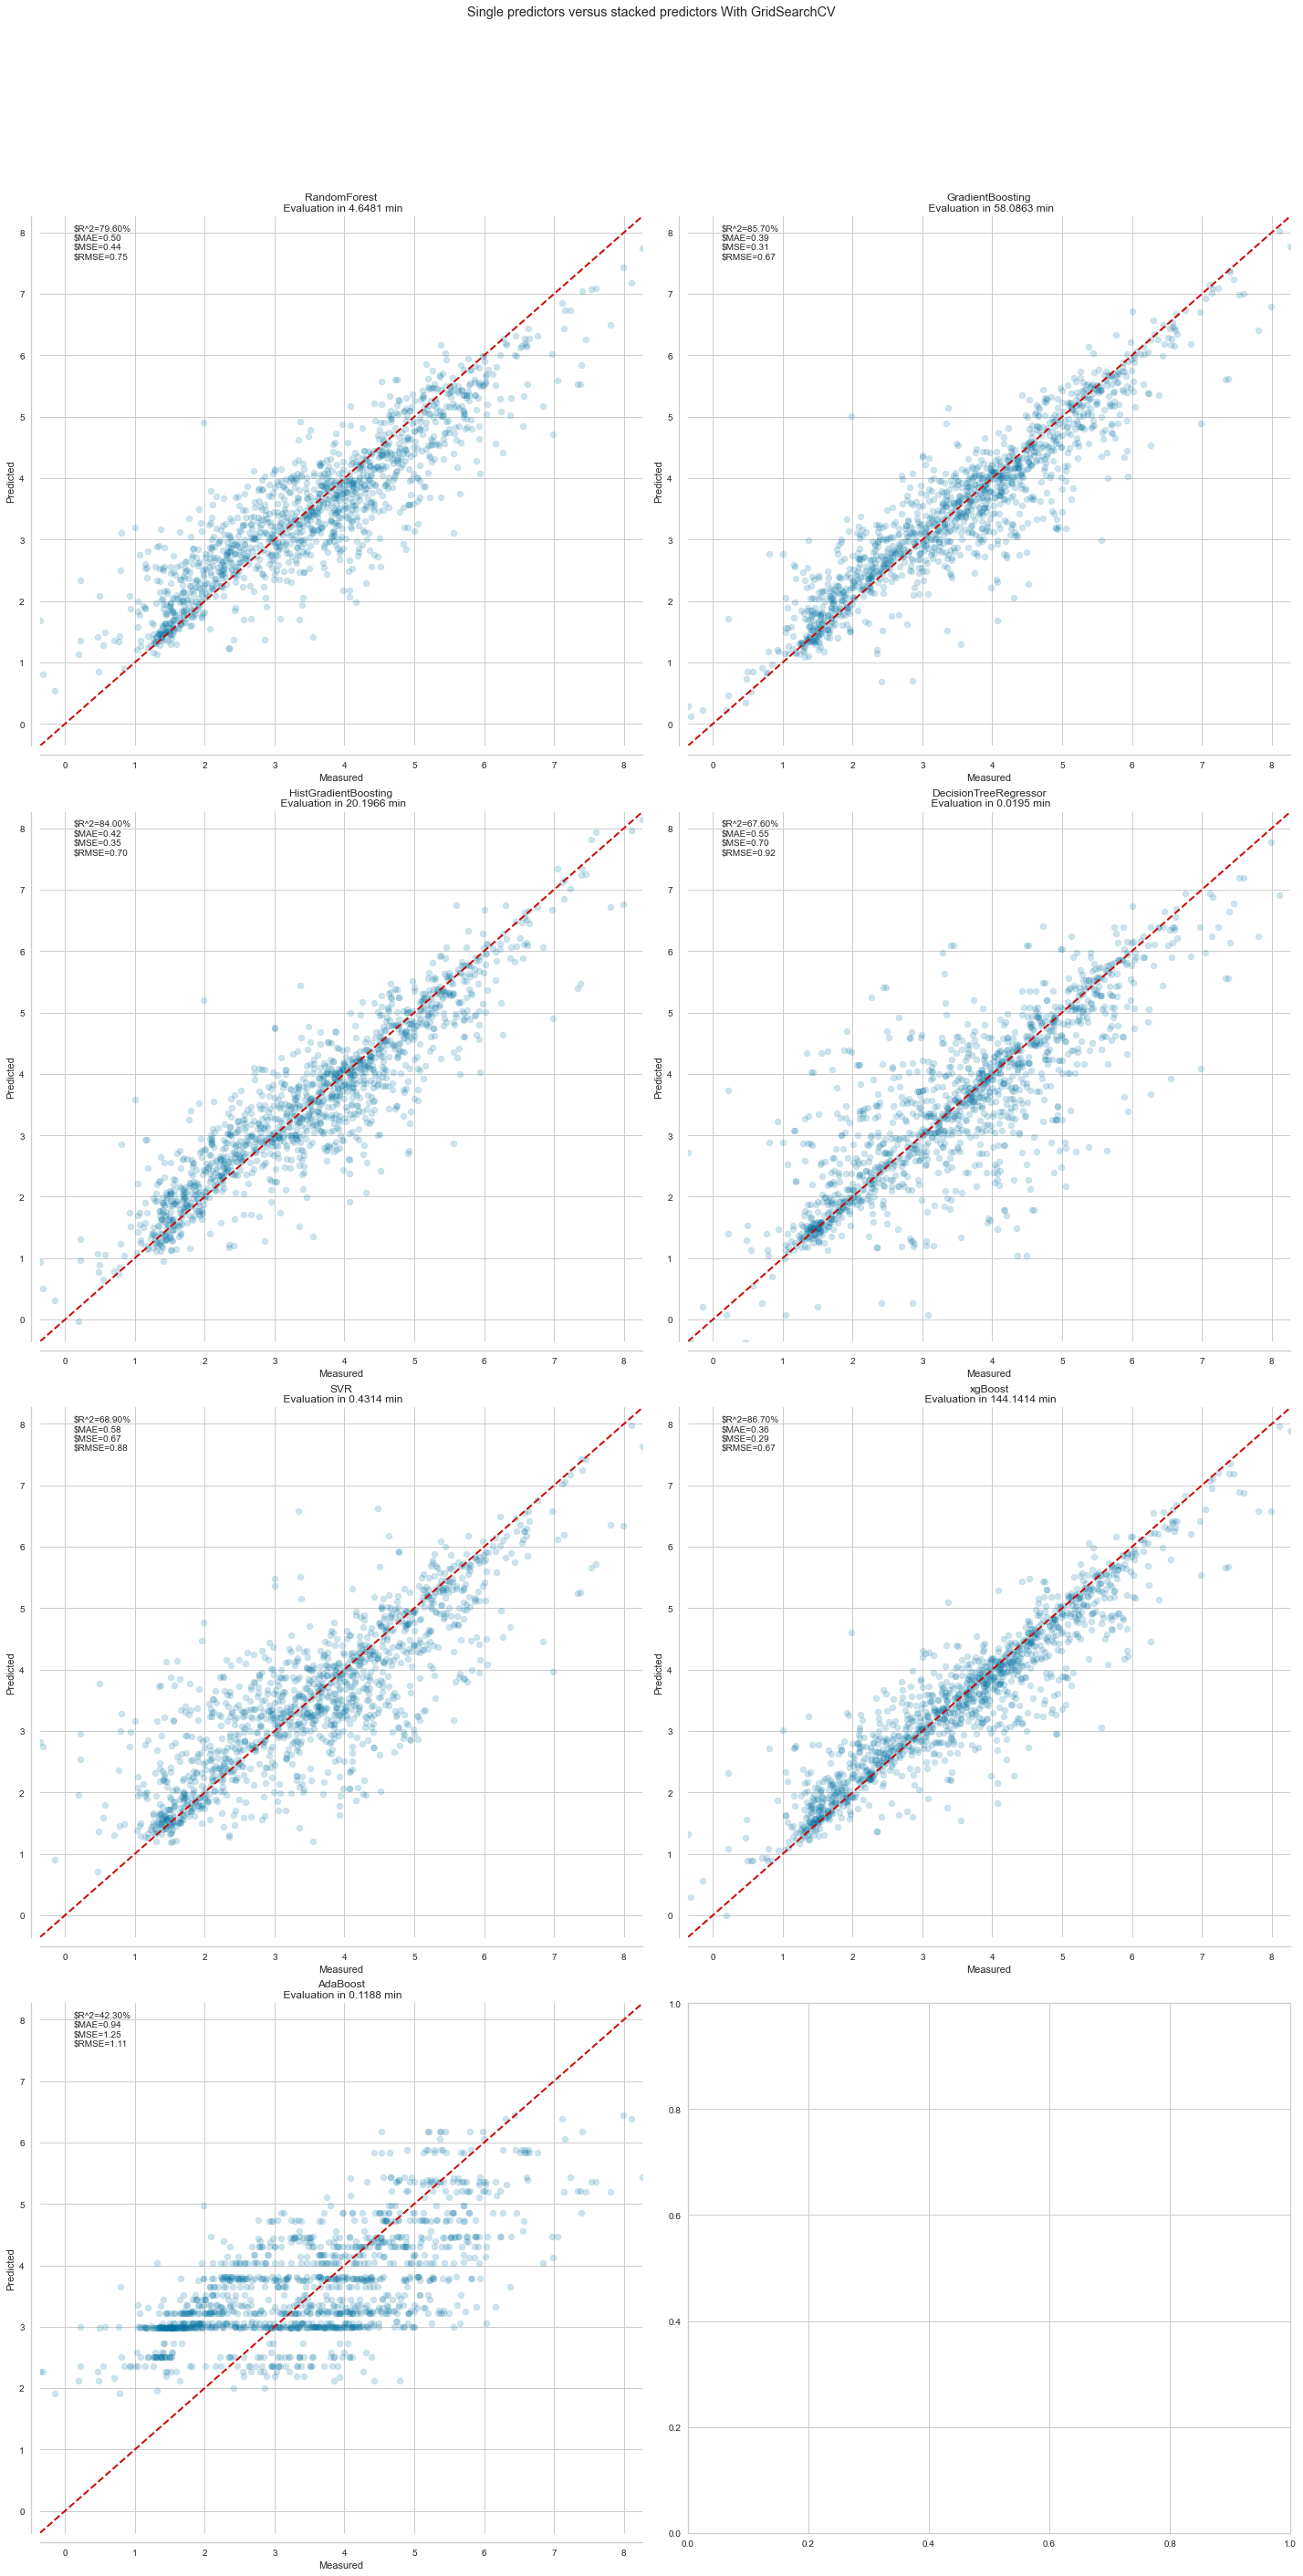

In [16]:
######################################### Utilisation de GridSearchCV ###################################################
# Appel de la fonction GridSearchCV : (estimators,parameters, cv,scoring,subplot_rows,subplot_columns,width_fig,height_fig):

Grid_Search (estimators_GridSCV, params_list_CO, 5, 'neg_root_mean_squared_error', 4, 2, 20, 40)

In [17]:
# Affichage du tableau final
print("")
eval_GSCV_model = pd.DataFrame(dict_metrics_GSCV, index=["MAE (GridSearchCV)", "MSE (GridSearchCV)", "RMSE (GridSearchCV)", "R² (GridSearchCV)", "elapsed_time (min)"])
eval_GSCV_model.columns = ["RandomForest", "GradientBoosting", "HistGradientBoosting", "DecisionTreeRegressor", "SVR", "xgBoost", "AdaBoost"]   
Tableau_final= pd.concat([eval_GSCV_model]) 
print("===============================================================================================================================")    
print("                 According to business requirements, the best Algoritrhm to predict energy consumption is : \n"                 )
print("===============================================================================================================================")        
print(final_model)


                 According to business requirements, the best Algoritrhm to predict energy consumption is : 

RandomForestRegressor(max_depth=120, min_samples_leaf=2, n_estimators=700,
                      n_jobs=-1, random_state=42)


In [18]:
Tableau_final = pd.concat([eval_GSCV_model]) 
print ("\n Evaluation des modèles par défaut VS modèles avec leurs meilleurs hyperparamètres :")
Tableau_final


 Evaluation des modèles par défaut VS modèles avec leurs meilleurs hyperparamètres :


RandomForest GradientBoosting HistGradientBoosting  \
MAE (GridSearchCV)          0.50             0.39                 0.42   
MSE (GridSearchCV)          0.44             0.31                 0.35   
RMSE (GridSearchCV)        -0.75            -0.67                -0.70   
R² (GridSearchCV)          79.60            85.70                84.00   
elapsed_time (min)          4.65            58.09                20.20   

                    DecisionTreeRegressor    SVR xgBoost AdaBoost  
MAE (GridSearchCV)                   0.55   0.58    0.36     0.94  
MSE (GridSearchCV)                   0.70   0.67    0.29     1.25  
RMSE (GridSearchCV)                 -0.92  -0.88   -0.67    -1.11  
R² (GridSearchCV)                   67.60  68.90   86.70    42.30  
elapsed_time (min)                   0.02   0.43  144.14     0.12

### overfitting/underffiting checking
Notre modèle final (RandomForest) ne présente pas d'overfitting. les deux erreurs diminuent continuellement et l'écart entre le train_score et le validation_score est de 0.35.

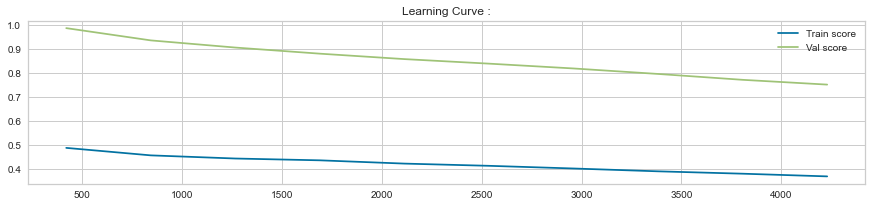

In [19]:
# Appel de la fonction évaludation des modèles  (model , X_train, y_train,X_test,cv,scoring)
evaluation (final_model, X_train, y_train, X_test, 5, 15, 3, 'neg_root_mean_squared_error') # neg_root_mean_squared_error

In [20]:
final_predictions_co2 = final_model.predict(X_test)

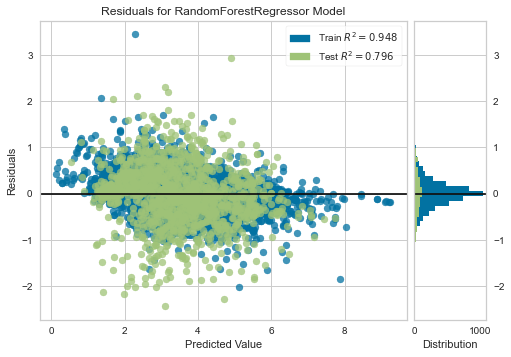

In [21]:
# Autre méthode de visualisation des résidus du modèle choisi " erreurs sur le train_set VS erreurs sur le test_set"
visualizer = ResidualsPlot(final_model)
visualizer.fit(np.array(X_train), np.array(y_train).reshape(5287,))
visualizer.score(np.array(X_test), np.array(y_test).reshape(1322,))
visualizer.show();


Erreurs de prédiction du modèle  RandomForestRegressor(max_depth=120, min_samples_leaf=2, n_estimators=700,
                      n_jobs=-1, random_state=42)  :


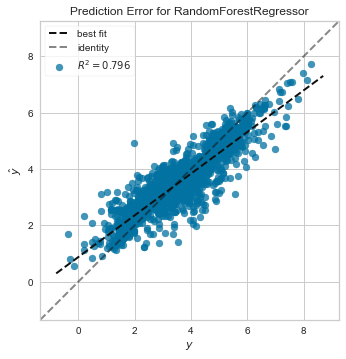

In [22]:
print("")
print("Erreurs de prédiction du modèle ",final_model," :")
visualizer = prediction_error(final_model, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));

## Feature importances

In [23]:
coefficients=abs(final_model.feature_importances_)

In [25]:
features=train_set.drop(["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "TotalGHGEmissions", "TotalGHGEmissions_log", "YearBuilt","Neighborhood", "Latitude", "Longitude"], axis=1).columns

In [26]:
liste_coefs_rer=pd.concat((pd.DataFrame(features, columns=['Variable']),
                          pd.DataFrame(coefficients, columns=['Coefficient'])), axis=1).sort_values(by='Coefficient', ascending=False)

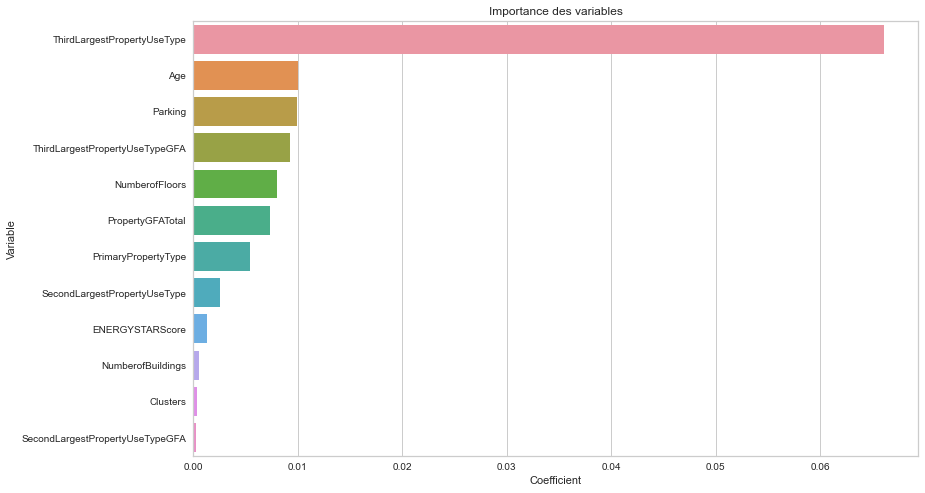

In [27]:
plt.figure(figsize=(13,8))
plt.title('Importance des variables')
sns.barplot(y=liste_coefs_rer['Variable'],
           x=liste_coefs_rer['Coefficient'])
plt.show()

Comme pour les deux modèles précédents, on remarque que la variable « ENERGYSTARScore » n’est pas importante pour notre modèle. On remarque également que le type d'usage tertiaire reste important pour notre modèle. Cependant, en ajoutant la variable, le classement est différent. De plus, le type d’usage principal ainsi que les clusters quittent le top 5 et sont remplacés par l’âge et parking. 

# Conclusion

Les informations dont l'on dispose nous permette d'avoir une bonne prédiction de la consommation d'énergie. On dispose d'un modèle qui capture 86% de la variance de notre phénomène. Les erreurs de prédictions sont plutôt faibles : une erreur de plus ou moins 0.1% est commise par notre modèle.

Concernant la prédiction de CO2, la prédiction semble moins fiable avec une erreur impoprtante. Ce modèle peut être utilisé pour nos prédictions mais il faudra prendre en compte que les erreurs sont plus importantes que pour la consommation d'énergie d'un bâtiment.